<a href="https://colab.research.google.com/github/dhar174/langgraph_system_generator/blob/main/sample_outputs/cyoa_c_notebook_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import annotations

## Configuration
Set runtime parameters and secrets.

In [ ]:
import os
from getpass import getpass
from pathlib import Path
from google.colab import userdata

# ---- Runtime config ----
WORKDIR = Path(os.getenv("WORKDIR", ".")).resolve()
WORKDIR.mkdir(parents=True, exist_ok=True)

# Pick any compatible OpenAI model (default: gpt-5-nano)
MODEL = os.getenv("MODEL", "gpt-5-nano")

# Defaults used across nodes (you can override per-call)
DEFAULT_TEMPERATURE = float(os.getenv("TEMPERATURE", "0.6"))
DEFAULT_MAX_TOKENS = int(os.getenv("MAX_OUTPUT_TOKENS", "900"))
DEFAULT_TIMEOUT_S = float(os.getenv("OPENAI_TIMEOUT_S", "60"))

# ---- API key ----
# If you don't set OPENAI_API_KEY in the environment, this will prompt once.
if not os.environ.get("OPENAI_API_KEY"):
  if userdata.get('OPENAI_API_KEY'):
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
  else:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OPENAI_API_KEY (kept local): ")

print(f"Using model: {MODEL}")
print(f"Working directory: {WORKDIR}")


Using model: gpt-5-nano
Working directory: /content


## Export Results
Persist outputs for downstream use.

In [ ]:
# import json
# from pathlib import Path

# # Use the graph variable defined in the previous cell
# if "graph" not in globals():
#     raise NameError("`graph` is not defined. Run the 'Graph Construction' cell before exporting results.")

# # Use the same thread_id as the UI (interactive-story-1 is the default)
# # If the user restarted, they might need to update this, but this is a safe default for the first run.
# config = {"configurable": {"thread_id": "interactive-story-1"}}

# # Get the latest state
# try:
#     snapshot = graph.get_state(config)
#     output_data = snapshot.values
#     if not output_data:
#         print("Warning: No state found for thread 'interactive-story-1'.")
#         output_data = {}
# except Exception as e:
#     print(f"Error retrieving state: {e}")
#     output_data = {}

# output_path = Path("graph_results.json")
# with output_path.open("w", encoding="utf-8") as handle:
#     json.dump(output_data, handle, indent=2, default=str)

# print(f"Saved results to {output_path.resolve()}")

## Troubleshooting
- Restart runtime if imports fail in Colab.
- Confirm `OPENAI_API_KEY` is set before running graph cells.
- Ensure pip installs complete before executing later cells.
- Review output JSON for unexpected schema mismatches.

# LangGraph Workflow: # Choose Your Own Adventure Story Engine (LangGrap

Generated by LangGraph Notebook Foundry

**Architecture**: hybrid  
**Patterns Used**: hybrid


## Overview

This notebook implements a LangGraph workflow using the **hybrid** pattern.

### Architecture Justification

The requirements align best with a hybrid LangGraph architecture that combines a central router for explicit flow control with a supervisor of specialized subagents. This pattern supports the explicit node roles and graph structure (story_gen_node, choice_gen_node, human_input_node, apply_choice_node, should_continue_router) while enabling modular, independent agent contexts for StoryWriter, ContinuityEditor, ChoiceArchitect, Lorekeeper, and an optional SafetyGuard. Rationale by capability:

- Task decomposition and modularity: A hybrid approach lets the router orchestrate high-level workflow while subagents encapsulate domain responsibilities. StoryWriter handles narrative generation; ContinuityEditor ensures coherence across turns; ChoiceArchitect validates and formats exactly 3 choices; Lorekeeper maintains world facts and memory; SafetyGuard enforces tone and safety constraints. This separation improves testability and clarity, and it maps cleanly to the explicit node interfaces and data flows required by the design.

- Specialized contexts vs shared state: Subagents provide isolated contexts per agent with well-defined interfaces, reducing cross-contamination of state. The Lorekeeper maintains a shared memory surface (facts, memory_summary) that all agents can reference, while each subagent can cache its own local state for efficiency.

- Parallel vs sequential execution: The supervisor can run certain subagent tasks in parallel when appropriate (for example, generating draft story and performing lightweight coherence checks concurrently) while the overall graph enforces the necessary sequential order: story_gen_node -> choice_gen_node -> human_input_node (interrupt) -> apply_choice_node -> should_continue_router. The hybrid pattern preserves this flow while enabling parallelizable micro-tasks within a single turn.

- State management and checkpointing: The architecture supports a clearly defined state schema and a robust checkpointing strategy. The router orchestrates checkpointing at interrupt points (before human_input_node), and both in-memory and SQLite-backed checkpointers can be used to resume after kernel restarts. Undo can revert to prior checkpoints, satisfying robustness and user-friendly rollback requirements.

- Guardrails and runtime constraints: A dedicated SafetyGuard agent enforces exact 3-choice rules, validates non-duplication and clarity of options, enforces the 150–300 word segment length bound, and stops on end conditions. The router enforces end conditions and coordinates transitions, ensuring violations are rejected gracefully and logged for telemetry if desired.

- Runtime UX and notebook compatibility: The interrupt-driven resume pattern aligns with a notebook run loop where the user sees a story segment, 3 choices, and then inputs a choice or a command (save/load/undo/quit). The hybrid approach cleanly separates the user-interaction boundary (router/interpreter) from generation/editing tasks (subagents), enabling straightforward implementation in a Jupyter/Colab environment with minimal dependencies.

- Extensibility and scalability: New agents or capabilities (inventory/traits, skill checks, style packs, branching saves) can be plugged into the subagent supervisor without destabilizing the core graph or the router, supporting future growth and multi-agent coordination across longer adventures or multiple story branches.

In summary, the hybrid pattern best satisfies the requirement for a modular, graph-driven, interruptable, and checkpointable system with clearly delineated agent roles and scalable orchestration. It leverages the router for flow control and subagents for specialized tasks, providing a robust blueprint for implementation and extension.

### Sections

1. Setup
1. State Definition
1. Tools
1. Nodes
1. Graph Construction
1. Execution


## Installation

Install the required packages:

In [ ]:
# Install required packages (Colab-friendly)
# langchain-openai >= 0.3.9 supports forcing the OpenAI Responses API via ChatOpenAI(use_responses_api=True)
!pip install -qU langgraph langchain-openai langchain-core langchain-community ipywidgets pypdf PyPDF2


## Configuration

Set initial prompt and story configuration:

In [ ]:
base_descriptors = ['self-discovery', 'Adventure', 'traveling the world', 'Redemption', 'Temptation', 'Justice vs mercy', 'Freedom vs Oppression', 'Liberation', 'Forbidden knowledge', 'intellectual discovery', 'the pursuit of knowledge', 'political intrigue', 'sacrifice', 'family bonds', 'devotion', 'faith', 'betrayal', 'isolation', 'extinction', 'ambition', 'tyranny','fate','time','destiny', 'causality', 'cycles', 'inevitability', 'second chances', 'mortality', 'belonging', 'alienation', 'social order', 'cultural collapse']

In [ ]:
import random

# Input from the user for several aspects of the desired story/scenario that will be used to create the initial prompt.
user_name = input("Enter your name: ")
user_age = input("Enter your age (must be a number): ")
user_pronouns = input("Enter your pronouns: ")

display("Enter the genre of the story, such as fantasy, romance, or horror:")
story_genre = input("Genre: ")

display("Enter the setting for the story. \n The setting can be a place or time: it can be another planet, world, dimension or universe; \n a real-world location like a city, country, or even very specific place. \n It can be another time or era, your imagination is the limit, just make sure it represents a place or time. \n And not too many words!:")
story_setting = input("Setting: ")

display("Enter the theme for the story. This should be a single word or a few words that are abstract and encapsulate the main idea of the story in a way more specific than genre (and not a place or time like setting).")
theme_examples = ", ".join(random.sample(base_descriptors, 5))
display(f"Some examples of good theme descriptors could be things like {theme_examples}")
story_theme = input("Theme: ")

input_data= {
    "user_name": user_name,
    "user_age": user_age,
    "user_pronouns":user_pronouns,
    "story_genre":story_genre,
    "story_setting":story_setting,
    "story_theme":story_theme,
}


Enter your name: Daddy
Enter your age (must be a number): 38
Enter your pronouns: He/Him


'Enter the genre of the story, such as fantasy, romance, or horror:'

Genre: Cosmic Horror


'Enter the setting for the story. \n The setting can be a place or time: it can be another planet, world, dimension or universe; \n a real-world location like a city, country, or even very specific place. \n It can be another time or era, your imagination is the limit, just make sure it represents a place or time. \n And not too many words!:'

Setting: 19th century Europe


'Enter the theme for the story. This should be a single word or a few words that are abstract and encapsulate the main idea of the story in a way more specific than genre (and not a place or time like setting).'

'Some examples of good theme descriptors could be things like faith, causality, Freedom vs Oppression, ambition, intellectual discovery'

Theme: abject terror, human insignificance, explicit adult body horror


## State Schema

Define the workflow state:

In [ ]:
from typing import Any, Dict, List, Optional, Annotated
import operator
from langgraph.graph import MessagesState

# Extend LangGraph's MessagesState
# (Includes 'messages' key with the built-in 'add_messages' reducer)
class WorkflowState(MessagesState):
    gen_id: str
    start_time: str
    last_turn_time: str
    user_age: int
    user_name:str
    user_pronouns:str

    # Turn / story tracking
    turn_index: int                                  # Default (overwrite) behavior is usually best for counters
    story_so_far: Annotated[List[str], operator.add] # Appends new segments to the list
    segment_summaries: Annotated[Dict[str, str], operator.or_] # Merges summaries, key is a tuple representing the beginning and ending original indices of the summarized segments
    current_segment: str
    current_segment_index: int

    recent_turns: List[dict] # where each dict stores a packed “turn” and its token count
    recent_tokens: int
    state_ledger: str
    # Choice loop
    choices: List[str]                               # Overwrite with new set of choices
    selected_choice: Optional[int]

    # World memory
    memory_summary: str
    # Uses dictionary union (|) to merge new facts into existing ones
    facts: Annotated[Dict[str, Any], operator.or_]
    chars: Annotated[Dict[str, Dict[str, Any]], operator.or_] # key: char name, value: dict with keys: relationships with other chars, relationship with player, appearance, backstory, recent char history, personality traits, etc.
    # items_lore: Annotated[Dict[str, Dict[str, Any]], operator.or_] # These are items that are known to exist, not necessarily in the players inventory
    locations: Annotated[Dict[str, Dict[str, Any]], operator.or_]
    events: Annotated[Dict[str, Dict[str, Any]], operator.or_] # Events that have occurred, irreversible
    # traits: Annotated[Dict[str, Dict[str, Any]], operator.or_] # player character traits
    inventory: Annotated[Dict[str, Dict[str, Any]], operator.or_] # Player current inventory
    # skills: Annotated[Dict[str, Dict[str, Any]], operator.or_] # Player skills
    # effects: Annotated[Dict[str, Dict[str, Any]], operator.or_] # Effects in play currently
    # relationships: Annotated[Dict[str, Dict[str, Any]], operator.or_] # These are the relationship

    facts_advice: List[str]
    memadvice: Dict[str,Any]
    # Tone / constraints
    tone: Annotated[Dict[str, Any], operator.or_]
    world_rules: Annotated[Dict[str, Any], operator.or_]

    # Run lifecycle
    run_status: str                                  # 'running' | 'waiting_for_human' | 'ended'
    end_reason: Optional[str]
    max_turns: int

    # Optional telemetry
    telemetry: Annotated[List[Dict[str, Any]], operator.add] # Appends new log entries

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

## Checkpointer, InMemoryStore and node cache

In [ ]:
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
# we'll also need a cache and a store
from langgraph.cache.memory import InMemoryCache
from langgraph.types import CachePolicy
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore
#import message classes
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from dataclasses import dataclass, field
from typing import Callable, Deque, List, Optional, Tuple
from collections import deque

import tiktoken  # pip install tiktoken  :contentReference[oaicite:1]{index=1}

# Create store with semantic search enabled
embeddings = init_embeddings("openai:text-embedding-3-small")
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
    }
)

# store.put(("user_123", "memories"), "1", {"text": "I love pizza"})
# store.put(("user_123", "memories"), "2", {"text": "I am a plumber"})

# items = store.search(
#     ("user_123", "memories"), query="I'm hungry", limit=1
# )
# Create graph
workflow = StateGraph(WorkflowState)
memory = MemorySaver()

## Tools

Define tools used in the workflow:

In [ ]:
# Helper utilities + StoryWriter tool (LangChain ChatOpenAI w/ Responses API)

from typing import Any, Dict, List, Optional, Union
import os
import json
import re

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage

def _ai_message_to_text(ai_msg: Any) -> str:
    """Best-effort extraction of plain text from LangChain AIMessage across output versions."""
    if ai_msg is None:
        return ""
    # Some LangChain builds expose .text for Responses API convenience
    txt = getattr(ai_msg, "text", None)
    if isinstance(txt, str) and txt.strip():
        return txt.strip()

    content = getattr(ai_msg, "content", ai_msg)
    if isinstance(content, str):
        return content.strip()

    # responses/v1 often stores a list of content blocks
    if isinstance(content, list):
        parts: List[str] = []
        for item in content:
            if isinstance(item, dict):
                if item.get("type") == "text" and isinstance(item.get("text"), str):
                    parts.append(item["text"])
                # Some variants nest under item['text']['value']
                elif "text" in item and isinstance(item["text"], dict) and isinstance(item["text"].get("value"), str):
                    parts.append(item["text"]["value"])
            elif isinstance(item, str):
                parts.append(item)
        return "\n".join(p for p in parts if p).strip()

    return str(content).strip()

def make_llm(
    model: Optional[str] = None,
    temperature: Optional[float] = None,
    max_tokens: Optional[int] = None,
    timeout: Optional[float] = None,
) -> ChatOpenAI:
    """Create a ChatOpenAI client configured to use the OpenAI Responses API."""
    model = model or os.getenv("MODEL", "gpt-5-nano")
    temperature = float(temperature if temperature is not None else os.getenv("TEMPERATURE", "0.6"))
    max_tokens = int(max_tokens if max_tokens is not None else os.getenv("MAX_OUTPUT_TOKENS", "900"))
    timeout = float(timeout if timeout is not None else os.getenv("OPENAI_TIMEOUT_S", "60"))

    return ChatOpenAI(model=model,
                           use_responses_api=True,
                           output_version="responses/v1",
                           max_completion_tokens =max_tokens,  # alias of max_completion_tokens :contentReference[oaicite:5]{index=5}
                           timeout=timeout,
                           reasoning={'effort': 'low','summary': 'auto'},
                           model_kwargs={'text': {'verbosity': 'high'}})

def _format_facts(facts: Any) -> str:
    try:
        if facts is None:
            return "none"
        if isinstance(facts, dict):
            return ", ".join([f"{k}={v}" for k, v in facts.items()]) or "none"
        if isinstance(facts, list):
            return "\n".join([f"- {x}" for x in facts]) or "none"
        return str(facts)
    except Exception:
        return "none"

def LLM_StoryWriter(
    turn_index: int,
    user_info:str,
    story_so_far: Optional[List[str]] = None,
    memory_summary: Optional[str] = None,
    facts: Optional[Dict[str, Any]] = None,
    tone: Optional[Dict[str, Any]] = None,
    model: Optional[str] = None,
    temperature: float = 0.6,
    max_tokens: int = 900,
    timeout: float = 60.0,
):
    """
    Produce a vivid 150–300 word narrative segment for the current turn.
    Uses langchain-openai's ChatOpenAI with the OpenAI Responses API.
    """
    story_so_far = story_so_far or []
    memory_summary = memory_summary or ""
    facts = facts or {}
    tone = tone or {"style": "adventure", "profanity_guard": True, "thematic_boundaries": []}

    llm = make_llm(model=model, temperature=temperature, max_tokens=max_tokens, timeout=timeout)

    system_msg = SystemMessage(content="You are StoryWriter, a collaborative narrative AI novelist.")
    user_msg = HumanMessage(content=(
        f"Write a cohesive, vivid, 150–300 word narrative segment for turn {turn_index + 1} of a fantasy adventure. "
        f"The user is {user_info} \n"
        f"Continue the tale from: {' '.join(story_so_far) if story_so_far else 'the beginning of the tale'}. "
        f"World memory summary: {memory_summary or 'none'}. "
        f"Known facts: {_format_facts(facts)}. "
        f"Tone constraints: {tone}. "
        "End the segment with a clear setup for three player choices."
    ))

    ai = llm.invoke([system_msg, user_msg])
    return _ai_message_to_text(ai) or "(StoryWriter fallback: no content)"


In [ ]:
# Tool: llm_continuity_editor (ChatOpenAI + Responses API)

from typing import Optional, List, Dict, Any, Union
import json

from langchain_core.messages import SystemMessage, HumanMessage

def llm_continuity_editor(
    segment: str,
    memory_facts: Optional[Union[str, List[str], Dict[str, Any]]] = None,
    continuity_constraints: Optional[Union[str, List[str]]] = None,
    system_prompt: Optional[str] = None,
    model: str = None,  # defaults to env MODEL
    temperature: float = 0.55,
    max_tokens: int = 450,
    timeout: float = 60.0,
) -> str:
    """Refine a draft segment to maintain coherence with story/memory and preserve voice."""

    def _format_collection(value) -> str:
        if value is None:
            return ""
        if isinstance(value, str):
            return value.strip()
        if isinstance(value, dict):
            return json.dumps(value, ensure_ascii=False, indent=2)
        if isinstance(value, list):
            return "\n".join(f"- {str(item)}" for item in value)
        try:
            return str(value)
        except Exception:
            return json.dumps(value, ensure_ascii=False)

    sys = system_prompt or "Ensure coherence with memory, resolve inconsistencies, and preserve voice."
    mem_text = _format_collection(memory_facts)
    cons_text = _format_collection(continuity_constraints)

    llm = make_llm(model=model, temperature=temperature, max_tokens=max_tokens, timeout=timeout)

    messages = [
        SystemMessage(content=f"You are ContinuityEditor. {sys}"),
        HumanMessage(content=(
            "Refine the following draft to maintain coherence. "
            f"Memory facts:\n{mem_text or 'none'}\n\n"
            f"Continuity constraints:\n{cons_text or 'none'}\n\n"
            f"Draft segment:\n{segment}\n\n"
            "Output ONLY the refined segment."
        )),
    ]
    ai = llm.invoke(messages)
    return _ai_message_to_text(ai) or segment


In [ ]:
# Tool: LLM_Lorekeeper (ChatOpenAI + Responses API)

from typing import Optional, Dict, Any
import json
import re

from langchain_core.messages import SystemMessage, HumanMessage

def _extract_json_from_text(text: str):
    try:
        return json.loads(text)
    except Exception:
        pass
    m = re.search(r"\{.*\}", text, re.S)
    if m:
        try:
            return json.loads(m.group(0))
        except Exception:
            return None
    return None

def LLM_Lorekeeper(
    segment: str,
    prior_memory_summary: str = "",
    prior_facts: Optional[Dict[str, Any]] = None,
    model: str = None,
    temperature: float = 0.25,
    max_tokens: int = 450,
    timeout: float = 60.0,
):
    """
    Update memory_summary (1–2 sentences) and facts (dict) based on latest segment.
    Returns: {"memory_summary": str, "facts": dict}
    """
    prior_facts = prior_facts or {}
    llm = make_llm(model=model, temperature=temperature, max_tokens=max_tokens, timeout=timeout)

    messages = [
        SystemMessage(content="You are Lorekeeper. Maintain a compact world memory and explicit facts."),
        HumanMessage(content=(
            "Given the latest story segment, output STRICT JSON with keys: "
            "memory_summary (string) and facts (object).\n\n"
            f"Prior memory_summary:\n{prior_memory_summary or 'none'}\n\n"
            f"Prior facts:\n{json.dumps(prior_facts, ensure_ascii=False, indent=2)}\n\n"
            f"Latest segment:\n{segment}\n"
        ))
    ]
    ai = llm.invoke(messages)
    txt = _ai_message_to_text(ai)
    parsed = _extract_json_from_text(txt) if txt else None

    if isinstance(parsed, dict) and "memory_summary" in parsed and "facts" in parsed:
        facts_out = parsed.get("facts") if isinstance(parsed.get("facts"), dict) else {}
        return {
            "memory_summary": str(parsed.get("memory_summary", "")).strip(),
            "facts": {**prior_facts, **facts_out},
        }

    # Fallback if JSON isn't valid
    return {
        "memory_summary": (txt or prior_memory_summary or "").strip()[:512],
        "facts": prior_facts,
    }


In [ ]:
# Tool: llm_safety_guard (ChatOpenAI + Responses API)

from typing import Dict, Any, Optional
import json

from langchain_core.messages import SystemMessage, HumanMessage

def llm_safety_guard(
    segment: str,
    tone: Optional[Dict[str, Any]] = None,
    model: str = None,
    temperature: float = 0.2,
    max_tokens: int = 450,
    timeout: float = 60.0,
) -> str:
    """Adjust content for safety and tone alignment while preserving narrative flow."""
    tone = tone or {"style": "adventure", "profanity_guard": True, "thematic_boundaries": []}
    llm = make_llm(model=model, temperature=temperature, max_tokens=max_tokens, timeout=timeout)

    messages = [
        SystemMessage(content="You are SafetyGuard. Ensure output is safe and matches the requested tone."),
        HumanMessage(content=(
            "Review and adjust the segment for safety, language appropriateness, and tone alignment. "
            f"Constraints (JSON):\n{json.dumps(tone, ensure_ascii=False)}\n\n"
            f"Segment:\n{segment}\n\n"
            "Output ONLY the revised segment."
        ))
    ]
    ai = llm.invoke(messages)
    return _ai_message_to_text(ai) or segment


In [ ]:
# Tool: LLM_ChoiceArchitect (ChatOpenAI + Responses API)

from typing import List, Dict, Any, Optional
import json
import re

from langchain_core.messages import SystemMessage, HumanMessage

def _extract_json_choices(text: str) -> List[str]:
    # Try strict JSON object {"choices":[...]}
    try:
        obj = json.loads(text)
        if isinstance(obj, dict) and isinstance(obj.get("choices"), list):
            return [str(x).strip() for x in obj["choices"] if str(x).strip()][:3]
    except Exception:
        pass
    # Try to extract {...}
    m = re.search(r"\{.*\}", text, re.S)
    if m:
        try:
            obj = json.loads(m.group(0))
            if isinstance(obj, dict) and isinstance(obj.get("choices"), list):
                return [str(x).strip() for x in obj["choices"] if str(x).strip()][:3]
        except Exception:
            pass
    # Line fallback
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    cleaned=[]
    for l in lines:
        l = re.sub(r"^[\-\*\d\.\)\s]+", "", l).strip()
        if l:
            cleaned.append(l)
    return cleaned[:3]

def LLM_ChoiceArchitect(
    current_segment: str,
    memory_summary: str = "",
    facts: Optional[Dict[str, Any]] = None,
    model: str = "gpt-5-nano",
    temperature: float = 0.4,
    max_tokens: int = 350,
    timeout: float = 60.0,
) -> List[str]:
    """Generate exactly 3 concise action-oriented choices as JSON."""
    facts = facts or {}
    llm = make_llm(model=model, temperature=temperature, max_tokens=max_tokens, timeout=timeout)

    messages = [
        SystemMessage(content="You are ChoicesDesigner. Generate 3 distinct next-step options."),
        HumanMessage(content=(
            "Return STRICT JSON with a top-level key 'choices' whose value is an array of exactly three strings.\n\n"
            f"Memory summary: {memory_summary or 'none'}\n"
            f"Facts: {json.dumps(facts, ensure_ascii=False)}\n\n"
            f"Current segment:\n{current_segment}\n"
        ))
    ]
    ai = llm.invoke(messages)
    txt = _ai_message_to_text(ai)
    choices = _extract_json_choices(txt) if txt else []
    if len(choices) < 3:
        # Fill deterministically
        filler = [
            "Investigate the mysterious gate and its inscriptions.",
            "Consult a trusted companion about recent omens.",
            "Pursue the strange light toward the forest's edge.",
        ]
        for f in filler:
            if len(choices) >= 3:
                break
            if f not in choices:
                choices.append(f)
    return choices[:3]


In [ ]:
# Tool: PythonSandbox
# Purpose: Run the agent orchestration code in a safe sandbox to produce the next state and segment based on the chosen flow.
# Category: Code execution

def run_agent_sandbox(
    flow_name: str,
    orchestration_code: str,
    initial_state: dict,
    timeout_sec: int = 60,
    sandbox: str = 'secure',
    libraries: list[str] | None = None
) :
    """
    Execute agent orchestration code inside a lightweight, soft sandbox to produce the next state
    and segment for the given flow.

    This function uses a restricted in-process sandbox with a time-limited execution thread.
    It enforces a whitelisting strategy for imports and exposes a minimal, safeTools API to the code.

    Important:
    - The orchestration_code must define a function with the signature:
        def orchestrate(state: MessagesState, tools: dict)
      and must return a dict containing at least:
        {'next_state': ..., 'segment': ...}
    - The function returns a dict with keys:
        - success: bool
        - next_state: dict (if success)
        - segment: str (if success)
        - execution_time_sec: float (if success)
        - error: str (if not success)
        - traceback: str (if not success)

    Parameters:
        flow_name: Name of the flow being executed (used for debugging/context).
        orchestration_code: Python source that defines orchestrate(state, tools).
        initial_state: The initial state dictionary fed to orchestrate.
        timeout_sec: Maximum allowed runtime in seconds.
        sandbox: Sandbox mode indicator (present for compatibility; this soft sandbox ignores mode).
        libraries: Optional list of whitelisted modules that the orchestration code may import.

    Returns:
        A dictionary describing the outcome of the sandboxed execution.
    """
    if not isinstance(initial_state, dict):
        return {'success': False, 'error': 'initial_state must be a dict.'}

    if libraries is None:
        libraries = []

    # Internal worker executed in a separate thread to allow timeouts.
    from concurrent.futures import ThreadPoolExecutor, TimeoutError
    import time

    def _sandbox_task(result_holder):
        try:
            # Build a restricted set of builtins
            import builtins as _builtins
            _allowed_names = [
                'abs', 'all', 'any', 'bool', 'bytes', 'chr', 'dict', 'enumerate', 'float',
                'int', 'len', 'list', 'map', 'max', 'min', 'next', 'object', 'pow',
                'range', 'repr', 'reversed', 'round', 'set', 'slice', 'sorted', 'str',
                'sum', 'tuple', 'print', 'type', 'isinstance', 'issubclass', 'dir',
                'getattr', 'hasattr', 'setattr', 'help'
            ]
            safe_builtins = {}
            for name in _allowed_names:
                if hasattr(_builtins, name):
                    safe_builtins[name] = getattr(_builtins, name)

            # Real import function to delegate allowed imports
            _real_import = __import__

            allowed_modules = set(libraries)

            def _safe_import(name, globals=None, locals=None, fromlist=(), level=0):
                top = name.split('.')[0]
                if top in allowed_modules or top in {'json', 'typing', 'sqlite3', 'openai'}:
                    return _real_import(name, globals, locals, fromlist, level)
                raise ImportError(f"Import of module '{name}' is not allowed in sandbox")

            safe_builtins['__import__'] = _safe_import

            sandbox_globals = {
                '__builtins__': safe_builtins,
                '__name__': '__sandbox__',
                '__doc__': None,
            }

            # Lightweight tools API exposed to orchestrate function
            storage = {}
            logs = []

            def _log(msg):
                logs.append(str(msg))

            def _storage_get(key, default=None):
                return storage.get(key, default)

            def _storage_set(key, value):
                storage[key] = value

            tools = {
                'log': _log,
                'storage_get': _storage_get,
                'storage_set': _storage_set,
                'storage': storage,
            }

            # Execute the orchestration code
            exec(orchestration_code, sandbox_globals)

            if 'orchestrate' not in sandbox_globals:
                raise RuntimeError("Sandbox code must define a function named 'orchestrate(state, tools)'")

            orchestrate = sandbox_globals['orchestrate']
            if not callable(orchestrate):
                raise TypeError("'orchestrate' must be a function")

            start = time.time()
            result = orchestrate(initial_state, tools)
            elapsed = time.time() - start

            if not isinstance(result, dict):
                raise TypeError("orchestrate must return a dict with 'next_state' and 'segment'")

            if 'next_state' not in result or 'segment' not in result:
                raise KeyError("Result must include 'next_state' and 'segment'")

            if not isinstance(result['next_state'], dict):
                raise TypeError("'next_state' must be a dict")

            out = {
                'success': True,
                'next_state': result['next_state'],
                'segment': result['segment'],
                'execution_time_sec': elapsed
            }
            result_holder.append(out)
        except Exception as e:
            import traceback
            tb = traceback.format_exc()
            result_holder.append({'success': False, 'error': str(e), 'traceback': tb})

    # Normalize input
    if initial_state is None:
        initial_state = {}

    result_holder = []
    with ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(_sandbox_task, result_holder)
        try:
            future.result(timeout=timeout_sec)
        except TimeoutError:
            return {'success': False, 'error': f'Sandbox execution timed out after {timeout_sec} seconds.'}
        except Exception as e:
            return {'success': False, 'error': f'Unexpected error during sandbox execution: {e}'}

    if not result_holder:
        return {'success': False, 'error': 'Sandbox did not return any result.'}

    res = result_holder[0]
    if not isinstance(res, dict):
        return {'success': False, 'error': 'Sandbox returned invalid result format.'}

    return res

In [ ]:
# Tool: PromptOrchestrator
# Purpose: Assemble and manage the prompts sent to each agent (StoryWriter, ContinuityEditor, Lorekeeper, SafetyGuard, ChoiceArchitect) and collect their outputs into a unified state.
# Category: Data processing
from typing import Any, Callable, Dict, List, Optional
def prompt_orchestrator(config: dict, seed: str | None = None, agent_executor: Callable | None = None, initial_state: dict | None = None) :
    """
    PromptOrchestrator

    Orchestrates prompts across a chain of agents (StoryWriter -> ContinuityEditor -> Lorekeeper -> SafetyGuard)
    and a separate ChoiceArchitect process to generate branching choices. Produces a unified, structured
    state containing the final story, lore, safety status, and generated choices.

    Parameters:
    - config: dict containing at least:
        - 'prompt_pipeline': list of strings describing prompt chains. Example:
          ['StoryWriter -> ContinuityEditor -> Lorekeeper -> SafetyGuard', 'ChoiceArchitect for choices generation']
        - 'output_format': currently expected to be 'structured_state'
    - seed: optional seed string used to initialize storytelling context.
    - agent_executor: optional callable(agent_name: str, prompt: str, context: dict)
        If provided, it will be used to invoke agents externally. The callable should return a dict with at least
        an 'output' key. It may also return 'lore', 'safety', or 'choices' depending on the agent.
        Signature: dict = {'output': str, 'lore': dict, 'safety': dict, 'choices': list, 'notes': str, 'success': bool}
    - initial_state: optional dict to seed/override internal state before orchestration.

    Returns:
    - dict with keys:
      {'state': {
          'story_seed': str|None,
          'story_text': str|None,
          'edited_story': str|None,
          'lore': dict|None,
          'safety': dict|None,
          'choices': list|None
        },
       'config_used': dict,
       'logs': list[str],
       'success': bool
      }
    """
    # Import necessary libraries at function level
    import json
    import logging
    from typing import Any, Callable, Dict, List, Optional

    # Basic logger setup
    logger = logging.getLogger(__name__)
    if not logger.handlers:
        logging.basicConfig(level=logging.INFO)

    logs: List[str] = []

    # Validation
    if not isinstance(config, dict):
        raise TypeError("config must be a dictionary with 'prompt_pipeline' and 'output_format' keys.")
    pipeline = config.get('prompt_pipeline')
    if not isinstance(pipeline, list) or len(pipeline) == 0:
        raise ValueError("config['prompt_pipeline'] must be a non-empty list describing the prompt chains.")

    output_format = config.get('output_format')
    if output_format != 'structured_state':
        # For now, enforce structured_state as the supported output format
        logger.info("Output format '%s' is not explicitly supported; defaulting to 'structured_state'.", output_format)
    config_used = dict(config)  # shallow copy for reference

    # Initialize internal state
    state: Dict[str, Any] = {
        'story_seed': seed,
        'story_text': None,
        'edited_story': None,
        'lore': None,
        'safety': None,
        'choices': None
    }

    if initial_state:
        # Merge allowed keys only
        for k in ('story_seed', 'story_text', 'edited_story', 'lore', 'safety', 'choices'):
            if k in initial_state:
                state[k] = initial_state[k]

    # Helper: compose prompts for agents (local templates)
    def _compose_prompt(agent_name: str, ctx: Dict[str, Any]):
        try:
            if agent_name == 'StoryWriter':
                s = ctx.get('story_seed') or seed or ''
                base = "Write a vivid narrative beginning"
                return f"{base}. Seed: {s}. Context: {ctx.get('story_text', '')}".strip()
            if agent_name == 'ContinuityEditor':
                return f"Review the following story for logical continuity and tone: {ctx.get('story_text', '')}".strip()
            if agent_name == 'Lorekeeper':
                return f"Extract and summarize lore from the following edited story: {ctx.get('edited_story', '')}".strip()
            if agent_name == 'SafetyGuard':
                return f"Perform a safety review on the following story and propose edits if needed: {ctx.get('story_text', '') or ctx.get('edited_story', '')}".strip()
            if agent_name == 'ChoiceArchitect':
                return f"Generate branching story choices based on the current context. Story: {ctx.get('story_text', '') or ctx.get('edited_story', '')}; Lore: {ctx.get('lore', {})}".strip()
        except Exception:
            return ""

    # Helper: agent invocation (external or internal mock)
    def _invoke_agent(agent_name: str, prompt: str, context: Dict[str, Any]):
        # External executor provided
        if callable(agent_executor):
            result = agent_executor(agent_name, prompt, dict(context))
            if not isinstance(result, dict):
                raise ValueError(f"agent_executor for {agent_name} returned non-dict result.")
            return result

        # Internal mock implementations (deterministic, self-contained)
        if agent_name == 'StoryWriter':
            s_seed = context.get('story_seed') or ''
            base_story = f"{s_seed} A vivid scene unfolds with evocative imagery and a sense of possibility."
            if not s_seed:
                base_story = "An untold tale begins in a quiet place, inviting curiosity and wonder."
            return {'output': base_story, 'notes': 'Generated by internal mock StoryWriter.', 'success': True}
        elif agent_name == 'ContinuityEditor':
            story = context.get('story_text') or ''
            if not story:
                story = "A tale with potential begins here."
            # Simple continuity fix: ensure consistent tense and remove rare placeholders
            edited = story.replace("tale", "story").replace("Story", "Story")
            edited = edited.rstrip() + " [Edited for continuity by ContinuityEditor]"
            return {'output': edited, 'notes': 'Edited for continuity.', 'success': True}
        elif agent_name == 'Lorekeeper':
            edited_story = context.get('edited_story') or context.get('story_text') or ''
            # Simple mock lore extraction
            lore = {
                'world': 'Altoria',
                'characters': ['Ari', 'Kai'],
                'locations': ['Everspring Valley'],
                'timeline': 'T1-01',
                'themes': ['bold journeys', 'found family']
            }
            return {'lore': lore, 'output': '', 'notes': 'Lore extracted.', 'success': True}
        elif agent_name == 'SafetyGuard':
            story = context.get('story_text') or context.get('edited_story') or ''
            # Simple safety check: if contains prohibited word, flag (very naive)
            prohibited = {'hate', 'slur', 'extreme_violence'}
            flagged = any(w in story.lower() for w in prohibited)
            safety = {'flagged': flagged, 'notes': 'Safety review completed.'}
            if flagged:
                # naive remediation: append a safety note
                story = story + " [SafetyGuard: content flagged and adjusted]"
            return {'output': story, 'safety': safety, 'notes': 'Safety check complete.', 'success': True}
        elif agent_name == 'ChoiceArchitect':
            # Provide a deterministic set of choices
            choices = [
                {'id': 'c1', 'description': 'Travel to the ancient ruins', 'rationale': 'Expands exploration of lore and setting.'},
                {'id': 'c2', 'description': 'Introduce a mysterious mentor', 'rationale': 'Adds new guidance and tension.'},
                {'id': 'c3', 'description': 'Reveal a hidden truth about the antagonist', 'rationale': 'Raises stakes and suspense.'}
            ]
            return {'choices': choices, 'output': '', 'notes': 'Generated choices.', 'success': True}
        else:
            raise ValueError(f"Unknown agent: {agent_name}")

    # Track whether a ChoiceArchitect step exists
    choice_pipeline_present = any('ChoiceArchitect' in item for item in pipeline if isinstance(item, str))

    # Build and execute chains
    current_context: Dict[str, Any] = dict(state)  # copy to avoid mutating original state

    # Process prompt pipelines (excluding explicit ChoiceArchitect steps)
    for item in pipeline:
        if not isinstance(item, str):
            continue
        if 'ChoiceArchitect' in item:
            # Handled later
            continue
        # Parse agents in this chain (split by '->')
        agents = [tok.strip() for tok in item.split('->') if tok.strip()]
        # Filter to known agents
        agents = [a for a in agents if a in {'StoryWriter', 'ContinuityEditor', 'Lorekeeper', 'SafetyGuard'}]
        if not agents:
            continue

        for agent in agents:
            prompt = _compose_prompt(agent, current_context)
            try:
                res = _invoke_agent(agent, prompt, current_context)
            except Exception as e:
                err_msg = f"Agent {agent} invocation failed: {str(e)}"
                logger.error(err_msg)
                logs.append(err_msg)
                # Graceful degradation: stop pipeline on failure
                raise RuntimeError(err_msg) from e

            # Update context/state based on agent output
            if agent == 'StoryWriter':
                output = res.get('output')
                if output is not None:
                    current_context['story_text'] = output
                    logs.append(f"StoryWriter produced story_text: {len(str(output))} chars")
            elif agent == 'ContinuityEditor':
                edited = res.get('output')
                if edited is not None:
                    current_context['edited_story'] = edited
                    # If we have a story_text, keep it as the base
                    if current_context.get('story_text') is None:
                        current_context['story_text'] = edited
                    logs.append("ContinuityEditor produced edited_story")
            elif agent == 'Lorekeeper':
                lore = res.get('lore')
                if lore is not None:
                    current_context['lore'] = lore
                    logs.append("Lorekeeper extracted lore")
            elif agent == 'SafetyGuard':
                safety = res.get('safety')
                if safety is not None:
                    current_context['safety'] = safety
                # SafetyGuard might also return updated story text
                if res.get('output'):
                    current_context['story_text'] = res['output']
                logs.append("SafetyGuard performed safety check")

    # After chain, commit outputs to state
    state['story_text'] = current_context.get('story_text')
    state['edited_story'] = current_context.get('edited_story')
    state['lore'] = current_context.get('lore')
    state['safety'] = current_context.get('safety')

    # Process ChoiceArchitect if present
    if choice_pipeline_present:
        # Use current context to inform choices
        prompt = _compose_prompt('ChoiceArchitect', current_context)
        try:
            res = _invoke_agent('ChoiceArchitect', prompt, current_context)
        except Exception as e:
            err_msg = f"ChoiceArchitect invocation failed: {str(e)}"
            logger.error(err_msg)
            logs.append(err_msg)
            raise RuntimeError(err_msg) from e

        choices = res.get('choices')
        if choices is None:
            # If external agent didn't return choices under 'choices', try 'output'
            choices = res.get('output')
            if isinstance(choices, list):
                pass
        state['choices'] = choices if isinstance(choices, list) else []

        logs.append(f"ChoiceArchitect generated {len(state['choices']) if state['choices'] else 0} choices")

    # Final structured state
    structured_state = {
        'story_seed': state.get('story_seed'),
        'story_text': state.get('story_text'),
        'edited_story': state.get('edited_story'),
        'lore': state.get('lore'),
        'safety': state.get('safety'),
        'choices': state.get('choices')
    }

    result = {
        'state': structured_state,
        'config_used': config_used,
        'logs': logs,
        'success': True
    }

    return result

In [ ]:
# Tool: StoryGraphRouter
# Purpose: Enforce graph loop and end conditions; route from story_gen_node to choice_gen_node to interrupt point to apply_choice_node, and finally to should_continue_router or end_node.
# Category: Data processing

def StoryGraphRouter(graph: dict, state: dict, config: dict | None = None) :
    """
    StoryGraphRouter
    Routes through a story graph following the story_loop_v1 schema.

    Routing flow (deterministic, per configuration):
      - story_gen_node -> choice_gen_node
      - choice_gen_node -> one of the interrupt_points (e.g., human_input_node)
      - interrupt_point -> apply_choice_node
      - apply_choice_node -> should_continue_router
      - should_continue_router -> either end_node (if end conditions met) or story_gen_node (continue loop)

    End conditions supported:
      - quit / The End / user-provided end keywords contained in end_conditions
      - max_turns: based on configured max_turns or state.max_turns

    State:
      - current_node: id of the current node
      - turns: int counter for completed turns (defaults to 0)
      - last_input: last user input string (optional, used to trigger end conditions)

    Args:
      graph: Graph representation with keys:
        - 'nodes': dict[node_id] -> {'id': node_id, 'type': str, 'name': str?}
        - 'edges': dict[source_node_id] -> [target_node_id, ...]
      state: Mutable dictionary holding routing state. Will be updated in place.
      config: Optional overrides. If None, defaults from the function are used.

    Returns:
      dict with keys:
        - 'success': bool
        - 'next_node_id': str | None
        - 'state': dict (updated)
        - 'reason': str (informational)
        - 'error': str (on failure, if any)
    """
    # Local imports (import at function level as requested)
    from typing import Any, Dict, Optional, List

    # Default configuration
    default_config: Dict[str, Any] = {
        'graph_schema': 'story_loop_v1',
        'interrupt_points': ['human_input_node'],  # Node IDs
        'end_conditions': ['quit', 'The End', 'max_turns'],
        'max_turns': 6,
        'start_node_type': 'story_gen_node',
        'choice_node_type': 'choice_gen_node',
        'apply_node_type': 'apply_choice_node',
        'should_continue_type': 'should_continue_router',
        'end_node_type': 'end_node',
    }

    # Merge provided config
    cfg: Dict[str, Any] = dict(default_config)
    if config:
        cfg.update(config)

    # Basic graph validation
    try:
        if not isinstance(graph, dict):
            raise TypeError("graph must be a dictionary.")
        nodes = graph.get('nodes')
        edges = graph.get('edges')
        if not isinstance(nodes, dict) or not isinstance(edges, dict):
            raise ValueError("Graph must contain 'nodes' and 'edges' dictionaries.")
        # Ensure each node has an id and type
        for nid, n in nodes.items():
            if not isinstance(n, dict):
                raise ValueError(f"Node {nid} is not a dictionary.")
            if 'id' not in n or 'type' not in n:
                raise ValueError(f"Node {nid} must have 'id' and 'type' fields.")
        # Ensure edges are well-formed
        for src, dsts in edges.items():
            if not isinstance(dsts, list):
                raise ValueError(f"Edges for {src} must be a list.")
    except Exception as exc:
        return {
            'success': False,
            'next_node_id': None,
            'state': state,
            'reason': 'Graph validation failed.',
            'error': str(exc)
        }

    def _get_node(node_id: str) -> Optional[Dict[str, Any]]:
        return nodes.get(node_id)

    def _get_node_id_by_type(node_type: str) -> Optional[str]:
        for nid, nd in nodes.items():
            if nd.get('type') == node_type:
                return nid
        return None

    def _get_next_ids(node_id: str) -> List[str]:
        return edges.get(node_id, [])

    def _get_next_node_of_type(node_id: str, target_type: str) -> Optional[str]:
        next_ids = _get_next_ids(node_id)
        for nid in next_ids:
            nd = _get_node(nid)
            if nd and nd.get('type') == target_type:
                return nid
        return None

    # Initialize current node if not provided
    try:
        current_node_id = state.get('current_node')
        if current_node_id is None:
            start_id = _get_node_id_by_type(cfg['start_node_type'])
            if start_id is None:
                # Fallback to story_gen_node if provided
                start_id = _get_node_id_by_type('story_gen_node')  # type: ignore
            if start_id is None:
                raise ValueError("Unable to determine start node from graph.")
            current_node_id = start_id
            state['current_node'] = current_node_id

        current_node = _get_node(current_node_id)
        if current_node is None or 'type' not in current_node:
            raise ValueError(f"Current node '{current_node_id}' is invalid or missing 'type'.")

        current_type = current_node.get('type')
        next_node_id: Optional[str] = None

        # Routing logic per node type
        if current_type == 'story_gen_node' or current_type == cfg['start_node_type']:
            # Route to the choice_gen_node
            next_node_id = _get_next_node_of_type(current_node_id, cfg['choice_node_type'])
            if next_node_id is None:
                # Fallback to first available edge
                next_ids = _get_next_ids(current_node_id)
                next_node_id = next_ids[0] if next_ids else None

        elif current_type == cfg['choice_node_type']:
            # Route to an interrupt point if present; otherwise first next
            next_ids = _get_next_ids(current_node_id)
            chosen = None
            for nid in next_ids:
                if nid in cfg['interrupt_points']:
                    chosen = nid
                    break
            if chosen is None and next_ids:
                chosen = next_ids[0]
            next_node_id = chosen

        elif current_type in [*cfg['interrupt_points']]:
            # After interrupt point, go to apply_choice_node
            next_node_id = _get_next_node_of_type(current_node_id, cfg['apply_node_type'])
            if next_node_id is None:
                next_ids = _get_next_ids(current_node_id)
                next_node_id = next_ids[0] if next_ids else None

        elif current_type == cfg['apply_node_type']:
            # After applying choice, go to should_continue_router
            next_node_id = _get_next_node_of_type(current_node_id, cfg['should_continue_type'])
            if next_node_id is None:
                next_ids = _get_next_ids(current_node_id)
                next_node_id = next_ids[0] if next_ids else None

        elif current_type == cfg['should_continue_type']:
            # Decide to end or continue loop
            last_input = state.get('last_input')
            turns = int(state.get('turns', 0))
            max_turns = int(cfg.get('max_turns', 6))

            end_by_input = False
            end_conditions = [str(c).strip() for c in cfg['end_conditions']]

            # exclude 'max_turns' for input decision
            input_end_conditions = [c for c in end_conditions if c != 'max_turns']

            if isinstance(last_input, str) and last_input.strip() in input_end_conditions:
                end_by_input = True

            end_by_turns = turns >= max_turns

            if end_by_input or end_by_turns:
                end_node_id = _get_node_id_by_type(cfg['end_node_type'])
                if end_node_id is None:
                    raise ValueError(f"End node of type '{cfg['end_node_type']}' not found in graph.")
                next_node_id = end_node_id
            else:
                # Continue looping back to story_gen_node
                next_node_id = _get_node_id_by_type('story_gen_node')
                if next_node_id is None:
                    # Fallback to first available edge from should_continue_router
                    next_ids = _get_next_ids(current_node_id)
                    next_node_id = next_ids[0] if next_ids else None

        else:
            # Default fallback: go to story_gen_node if available
            next_node_id = _get_node_id_by_type('story_gen_node')
            if next_node_id is None:
                next_ids = _get_next_ids(current_node_id)
                next_node_id = next_ids[0] if next_ids else None

        if next_node_id is None:
            raise ValueError("Router could not determine a valid next node from current node.")

        # Update state for next iteration
        # Increment turns after completing a cycle that includes apply_choice_node or after the should_continue_router decision to continue
        # We increment when we move forward after applying a choice (i.e., current_type == apply_choice_node)
        if current_type == cfg['apply_node_type']:
            state['turns'] = int(state.get('turns', 0)) + 1

        # Persist the next node
        state['current_node'] = next_node_id

        return {
            'success': True,
            'next_node_id': next_node_id,
            'state': state,
            'reason': f"Routed from {current_type} (node {current_node_id}) to {nodes.get(next_node_id, {}).get('type', 'unknown')} (node {next_node_id})."
        }

    except Exception as exc:
        return {
            'success': False,
            'next_node_id': None,
            'state': state,
            'reason': 'Routing failed due to an internal error.',
            'error': str(exc)
        }

In [ ]:
# Tool: StateSchemaValidator
# Purpose: Validate the runtime state against the defined schema (turn_index, story_so_far, current_segment, choices, etc.) to catch invalid intermediate states.
# Category: Validation

def StateSchemaValidator(state: MessagesState, config: dict = None) :
    """
    Validate the given runtime state against a JSON Schema.

    This function:
    - Loads the JSON Schema from a configured path (default: schemas/state_schema.json).
    - Performs a top-level strict-mode check to ensure there are no unknown keys at the root.
    - Validates the state against the schema using jsonschema (Draft7).
    - Collects all validation errors and returns a structured result.

    Parameters:
        state (dict): The runtime state to validate. Expected to be a dictionary.
        config (dict, optional): Configuration for the validator.
            - 'schema_path' (str): Path to the JSON Schema file.
            - 'strict_mode' (bool): If True, disallow extra top-level keys not defined in the schema's properties.

    Returns:
        dict: A dictionary containing:
            - 'valid' (bool): Whether the state conforms to the schema.
            - 'errors' (list[str]): List of human-readable validation error messages.
            - 'schema_path' (str): Path to the used JSON Schema.
            - 'strict_mode' (bool): Whether strict mode was applied.
            - 'state' (dict): The original state that was validated.
    """
    # Local imports to satisfy the requirement of importing libraries at function level
    import json
    from pathlib import Path
    from typing import Dict, List, Any

    DEFAULT_CONFIG = {'schema_path': 'schemas/state_schema.json', 'strict_mode': True}

    # Normalize input
    if config is None:
        config = {}
    if not isinstance(state, dict):
        return {
            'valid': False,
            'errors': ["State must be a dictionary."],
            'schema_path': str(DEFAULT_CONFIG['schema_path']),
            'strict_mode': bool(config.get('strict_mode', DEFAULT_CONFIG['strict_mode'])),
            'state': state
        }

    schema_path = config.get('schema_path', DEFAULT_CONFIG['schema_path'])
    strict_mode = bool(config.get('strict_mode', DEFAULT_CONFIG['strict_mode']))

    errors: List[str] = []
    # Load and parse the schema
    try:
        schema_file = Path(schema_path)
        if not schema_file.is_file():
            errors.append(f"Schema file not found at path: {schema_path}")
            return {
                'valid': False,
                'errors': errors,
                'schema_path': str(schema_path),
                'strict_mode': strict_mode,
                'state': state
            }
        with open(schema_file, 'r', encoding='utf-8') as f:
            schema: Dict[str, Any] = json.load(f)
        if not isinstance(schema, dict):
            errors.append("Schema content must be a JSON object.")
            return {
                'valid': False,
                'errors': errors,
                'schema_path': str(schema_path),
                'strict_mode': strict_mode,
                'state': state
            }
    except json.JSONDecodeError as e:
        errors.append(f"Schema JSON decode error: {e}")
        return {
            'valid': False,
            'errors': errors,
            'schema_path': str(schema_path),
            'strict_mode': strict_mode,
            'state': state
        }
    except Exception as e:
        errors.append(f"Failed to load schema: {e}")
        return {
            'valid': False,
            'errors': errors,
            'schema_path': str(schema_path),
            'strict_mode': strict_mode,
            'state': state
        }

    # Strict mode: ensure no unknown top-level keys are present in the state
    if strict_mode:
        allowed_keys = set(schema.get('properties', {}).keys())
        if not isinstance(allowed_keys, set):
            allowed_keys = set(allowed_keys)
        state_keys = set(state.keys())
        extra_keys = sorted(state_keys - allowed_keys)
        if extra_keys:
            errors.append(f"Unknown top-level keys in state (not defined in schema properties): {extra_keys}")

    # Run JSON Schema validation
    try:
        # Use Draft7Validator for broad compatibility; jsonschema >=3.x supports Draft7 by default
        from jsonschema import Draft7Validator
        validator = Draft7Validator(schema)
        validation_errors = sorted(validator.iter_errors(state), key=lambda e: (list(e.path), e.path))
        for err in validation_errors:
            # Build a readable path string
            path = '.'.join([str(p) for p in err.path]) if err.path else '<root>'
            errors.append(f"{path}: {err.message}")
    except Exception as e:
        errors.append(f"Schema validation error: {e}")

    valid = len(errors) == 0

    return {
        'valid': valid,
        'errors': errors,
        'schema_path': str(schema_path),
        'strict_mode': strict_mode,
        'state': state
    }

In [ ]:
# Tool: WordCountEnforcer
# Purpose: Enforce the story_segment length constraint (150–300 words); compute word count and trigger adjustments if outside bounds.
# Category: Data processing

def enforce_word_count(story_segment: str, min_words: int = 150, max_words: int = 500) :
    """
    Enforce a word-count constraint on a story segment.

    This function computes the word count of the provided story_segment and ensures
    it lies within [min_words, max_words]. If the segment is too short, it will
    be expanded by appending predefined filler sentences until the minimum is reached
    (and then trimmed to the maximum if necessary). If the segment is too long, it will
    be truncated to max_words.

    Returns a dictionary containing:
    - original_word_count: Word count before adjustments
    - adjusted_word_count: Word count after adjustments
    - adjusted_story_segment: The resulting story segment after adjustments
    - status: The adjustment outcome ("within_bounds", "expanded_to_min",
              "trimmed_to_max", or "trimmed_to_max_after_expansion")
    - min_words, max_words: The configured bounds

    Parameters:
    - story_segment: str, input story segment to validate
    - min_words: int, minimum allowed word count (default 150)
    - max_words: int, maximum allowed word count (default 300)

    Raises:
    - TypeError: if input types are incorrect
    - ValueError: if bounds are invalid (negative or min > max)

    The function is designed to be deterministic and side-effect-free apart from the
    returned adjusted string.
    """
    # Local imports to satisfy "import at function level" requirement
    import re
    from typing import List

    # Simple, readable word counting: count tokens comprised of letters/digits and optional internal apostrophes
    def count_words(text: str) -> int:
        if not text:
            return 0
        tokens = re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?", text)
        return len(tokens)

    # Basic whitespace split for trimming/padding operations
    def split_words(text: str) -> List[str]:
        return text.split()

    def trim_to_word_bound(text: str, target_count: int) -> str:
        if target_count <= 0:
            return ""
        words = split_words(text)
        return " ".join(words[:target_count])

    # Filler sentences used to pad under-length story segments
    FILLER_SENTENCES = [
        "The narrative continued with careful description and added depth to the scene.",
        "Characters' motivations became clearer as the tension mounted.",
        "Rich sensory detail painted the setting and mood.",
        "Subtle shifts in pace kept the reader engaged and curious.",
        "A sense of momentum carried the story toward new possibilities."
    ]

    # Input validation
    if not isinstance(story_segment, str):
        raise TypeError("story_segment must be a string.")
    if not isinstance(min_words, int) or not isinstance(max_words, int):
        raise TypeError("min_words and max_words must be integers.")
    if min_words < 0 or max_words < 0:
        raise ValueError("min_words and max_words must be non-negative.")
    if min_words > max_words:
        raise ValueError("min_words cannot be greater than max_words.")

    original_word_count = count_words(story_segment)

    adjusted_story_segment = story_segment
    adjusted_word_count = original_word_count
    status = "within_bounds"

    if original_word_count < min_words:
        # Pad until we reach at least min_words
        idx = 0
        max_iterations = 1000  # safeguard against pathological inputs
        current = adjusted_story_segment
        current_count = original_word_count

        while current_count < min_words and max_iterations > 0:
            sentence_to_add = FILLER_SENTENCES[idx % len(FILLER_SENTENCES)]
            # Ensure we maintain readability by adding a space before appending
            current = (current + " " + sentence_to_add).strip()
            current_count = count_words(current)
            idx += 1
            max_iterations -= 1

        adjusted_story_segment = current
        adjusted_word_count = current_count

        # If padding pushed us over max_words, trim to max_words
        if adjusted_word_count > max_words:
            adjusted_story_segment = trim_to_word_bound(adjusted_story_segment, max_words)
            adjusted_word_count = max_words
            status = "trimmed_to_max_after_expansion"
        else:
            status = "expanded_to_min"
    elif original_word_count > max_words:
        # Truncate to max_words
        adjusted_story_segment = trim_to_word_bound(story_segment, max_words)
        adjusted_word_count = max_words
        status = "trimmed_to_max"

    # If exactly within bounds, leave as-is
    if original_word_count >= min_words and original_word_count <= max_words:
        adjusted_word_count = original_word_count
        adjusted_story_segment = story_segment
        status = "within_bounds"

    return {
        "original_word_count": original_word_count,
        "adjusted_word_count": adjusted_word_count,
        "adjusted_story_segment": adjusted_story_segment,
        "status": status,
        "min_words": min_words,
        "max_words": max_words,
    }

In [ ]:
# Tool: GuardrailEnforcer
# Purpose: Enforce exact 3 choices, validate 1–3 range, reject duplicates, and validate that choices are meaningful and non-vague.
# Category: Validation

def guardrail_enforce_choices(choices, config=None):
    """
    GuardrailEnforcer: Validates that a provided list of choices adheres to strict guardrail rules.

    Requirements enforced:
    - Exactly a specified number of choices (default: 3).
    - No duplicates unless allowed by configuration.
    - Each choice must be meaningful (non-vague) when min_quality is 'meaningful'.
    - Proper error handling with descriptive messages.

    Parameters:
        choices (list[str] | tuple[str, ...]): The user-provided choices to validate.
        config (dict | None): Optional configuration dict. Expected structure:
            {
                'constraints': {
                    'choices_count': int,      # e.g., 3
                    'allow_duplicates': bool,  # e.g., False
                    'min_quality': str         # e.g., 'meaningful'
                }
            }

    Returns:
        list[str]: The cleaned and validated list of choices.

    Raises:
        TypeError: If input types are incorrect.
        ValueError: If constraints are violated or choices are not meaningful.
    """
    import re

    # Default configuration
    defaults = {
        'choices_count': 3,
        'allow_duplicates': False,
        'min_quality': 'meaningful'
    }

    # Merge user config with defaults
    constraints = defaults.copy()
    if isinstance(config, dict):
        cfg = config.get('constraints')
        if isinstance(cfg, dict):
            constraints.update(cfg)

    # Validate input type
    if not isinstance(choices, (list, tuple)):
        raise TypeError("choices must be a list or tuple of strings.")
    if len(choices) == 0:
        raise ValueError("choices must contain at least one item.")

    # Normalize and sanitize inputs
    cleaned = []
    for idx, c in enumerate(choices):
        if not isinstance(c, str):
            raise TypeError(f"Choice at index {idx} is not a string.")
        cleaned.append(c.strip())

    # Enforce exact number of choices
    expected = constraints.get('choices_count')
    if not isinstance(expected, int) or expected <= 0:
        raise ValueError("Invalid configuration: 'choices_count' must be a positive integer.")
    if len(cleaned) != expected:
        raise ValueError(f"Exactly {expected} choices are required. Received {len(cleaned)}.")

    # Enforce duplicates policy
    allow_dup = constraints.get('allow_duplicates', False)
    if not allow_dup:
        normalized = [c.lower() for c in cleaned]
        if len(set(normalized)) != len(normalized):
            raise ValueError("Duplicate choices are not allowed by configuration.")

    # Validate minimum quality if requested
    min_quality = constraints.get('min_quality', 'meaningful')
    if min_quality == 'meaningful':
        def _is_meaningful(text: str) -> bool:
            s = text.strip()
            if len(s) < 3:
                return False
            if not re.search(r'[A-Za-z0-9]', s):
                return False

            lower = s.lower()

            vague_terms = {
                'option', 'options', 'choose', 'choosing', 'select', 'selection',
                'item', 'misc', 'miscellaneous', 'general', 'anything', 'something',
                'whatever', 'placeholder', 'to be decided', 'tbd', 'todo',
                'unidentified', 'untitled',
            }

            if lower in vague_terms:
                return False
            if re.match(r'option\s*\d+', lower) or re.match(r'choice\s*\d+', lower):
                return False

            # Remove common stopwords and evaluate for meaningful content
            stopwords = {
                'the','and','a','an','of','to','in','for','with','on','at','by','or',
                'is','are','as','be','this','that','these','those'
            }
            words = [w for w in re.split(r'\s+', lower) if w]
            meaningful_words = [w for w in words if w not in stopwords]

            return len(meaningful_words) >= 1

        for idx, ch in enumerate(cleaned):
            if not _is_meaningful(ch):
                raise ValueError(f"Choice at index {idx} ('{ch}') is not meaningful or is too vague.")

    # All checks passed; return the cleaned list
    return cleaned

In [ ]:
# Tool: JSONStateStore
# Purpose: Persist and load the in-memory state to disk as JSON for resilience across notebook restarts or kernel interruptions.
# Category: File I/O

def JSONStateStore(action: str, data=None, path: str = None, pretty_print: bool = None):
    """
    Persist and load in-memory state to disk as JSON.

    This function serves as a simple JSON-backed state store with atomic writes for resilience
    across notebook restarts or kernel interruptions. It supports two actions:
      - 'save': Persist the provided `data` to disk at the configured path.
      - 'load': Load and return the JSON state from disk. If the file does not exist, returns an empty dict.

    Configuration (defaults):
      path: 'state/state.json'
      pretty_print: True

    Parameters:
      action (str): 'save' to write state, 'load' to read state.
      data (Any): JSON-serializable object to save when action='save'. Ignored for action='load'.
      path (str): Optional override for the file path to store the JSON.
      pretty_print (bool): If True, pretty-prints JSON with indentation. If False or None, compact form.

    Returns:
      If action='save': dict with keys 'status' and 'path'.
      If action='load': the deserialized JSON object, or {} if the file does not exist.

    Raises:
      ValueError, OSError, or IOError on failure to save or load, with descriptive messages.
    """
    # Import libraries locally to satisfy "import at function level" requirement
    from pathlib import Path
    import json
    import os
    import tempfile
    from typing import Any

    # Default configuration
    DEFAULT_PATH = 'state/state.json'
    DEFAULT_PRETTY = True

    # Normalize inputs
    effective_path = Path(path) if path else Path(DEFAULT_PATH)
    is_pretty = DEFAULT_PRETTY if pretty_print is None else bool(pretty_print)

    if action not in {'save', 'load'}:
        raise ValueError("Invalid action. Use 'save' or 'load'.")

    try:
        if action == 'save':
            if data is None:
                raise ValueError("No data provided to save. Please provide a JSON-serializable object via the 'data' parameter.")

            # Quick JSON-serializability check
            try:
                json.dumps(data)
            except (TypeError, ValueError) as e:
                raise ValueError(f"Provided data is not JSON-serializable: {e}")

            indent = 2 if is_pretty else None

            try:
                # Ensure parent directory exists
                effective_path.parent.mkdir(parents=True, exist_ok=True)

                # Atomic write: write to a temp file, then atomically replace
                with tempfile.NamedTemporaryFile('w', encoding='utf-8', delete=False, dir=str(effective_path.parent)) as tmp:
                    json.dump(data, tmp, indent=indent)
                    tmp.flush()
                    os.fsync(tmp.fileno())
                    temp_path = Path(tmp.name)

                os.replace(str(temp_path), str(effective_path))

                return {"status": "success", "path": str(effective_path)}
            except OSError as e:
                raise IOError(f"Failed to write state to {effective_path}: {e}")

        else:  # action == 'load'
            if not effective_path.exists():
                # Gracefully return empty state if no persisted state is present
                return {}

            try:
                with effective_path.open('r', encoding='utf-8') as f:
                    return json.load(f)
            except json.JSONDecodeError as e:
                raise ValueError(f"Invalid JSON in state file {effective_path}: {e}")
            except OSError as e:
                raise IOError(f"Failed to read state file {effective_path}: {e}")

    except Exception:
        # Re-raise to preserve traceback for debugging
        raise

In [ ]:
# Tool: SQLiteCheckpointer
# Purpose: Persistent checkpointing using SQLite to enable resume after kernel restart or crash; supports named slots and versioning.
# Category: File I/O

def SQLiteCheckpointer(config):
    """
    Lightweight persistent checkpointing using SQLite.

    This tool provides a simple slot-based checkpointing mechanism with optional
    schema migration. It persists checkpoints in a SQLite database, enabling
    resumption after kernel restarts or crashes.

    Configuration (config dict):
      - db_path: Path to the SQLite database file (e.g., 'checkpoints/adventure.db')
      - table: Table name to store checkpoints (default: 'checkpoints')
      - slot_columns: List of column names for the slot (e.g., ['slot_id', 'timestamp', 'state_json', 'end_status'])
      - auto_migrate: If True, will auto-create or migrate the table as needed (default: False)

    Returned object exposes methods:
      - save_checkpoint(slot_id, state, end_status=None)
      - load_checkpoint(slot_id)  or None
      - list_slots() -> List[str]
      - delete_slot(slot_id) -> bool
      - close()
    """
    import sqlite3
    import json
    import re
    from datetime import datetime
    from pathlib import Path

    # Validate a simple SQL identifier (table/column name)
    def _validate_identifier(name: str) -> str:
        if not isinstance(name, str) or not re.match(r'^[A-Za-z_][A-Za-z0-9_]*$', name):
            raise ValueError(f"Invalid SQL identifier: {name}")
        return name

    if not isinstance(config, dict):
        raise ValueError("config must be a dictionary.")

    db_path = config.get('db_path')
    if not db_path:
        raise ValueError("config must include 'db_path'.")

    table = config.get('table', 'checkpoints')
    slot_columns = config.get('slot_columns', ['slot_id', 'timestamp', 'state_json', 'end_status'])
    auto_migrate = bool(config.get('auto_migrate', False))

    table = _validate_identifier(table)
    Path(db_path).parent.mkdir(parents=True, exist_ok=True)

    class _CheckpointerBackend:
        def __init__(self, db_path, table, slot_columns, auto_migrate):
            self.db_path = str(db_path)
            self.table = table
            self.slot_columns = list(slot_columns)
            self.auto_migrate = bool(auto_migrate)

            self._conn = sqlite3.connect(self.db_path, check_same_thread=False)
            self._conn.row_factory = sqlite3.Row
            self.SCHEMA_VERSION = 1  # hard-coded current schema version
            self._ensure_table()

        def _table_exists(self) -> bool:
            cur = self._conn.cursor()
            try:
                cur.execute("SELECT name FROM sqlite_master WHERE type='table' AND name=?", (self.table,))
                exists = cur.fetchone() is not None
                return exists
            finally:
                cur.close()

        def _get_existing_columns(self) -> set:
            cur = self._conn.cursor()
            try:
                cur.execute(f"PRAGMA table_info({self.table})")
                return {row['name'] for row in cur.fetchall()}
            finally:
                cur.close()

        def _ensure_table(self):
            cur = self._conn.cursor()
            try:
                if not self._table_exists():
                    if not self.auto_migrate:
                        raise RuntimeError(f"Table '{self.table}' does not exist and auto_migrate is disabled.")
                    # Create base table with required columns
                    cur.execute(f"""
                        CREATE TABLE IF NOT EXISTS {self.table} (
                            slot_id TEXT PRIMARY KEY,
                            timestamp TEXT NOT NULL,
                            state_json TEXT,
                            end_status TEXT
                        )
                    """)
                    # Metadata table for schema versioning
                    cur.execute("""
                        CREATE TABLE IF NOT EXISTS checkpoints_meta (
                            key TEXT PRIMARY KEY,
                            value TEXT
                        )
                    """)
                    cur.execute("SELECT value FROM checkpoints_meta WHERE key='schema_version'")
                    if cur.fetchone() is None:
                        cur.execute("INSERT INTO checkpoints_meta (key, value) VALUES ('schema_version', ?)", (str(self.SCHEMA_VERSION),))
                    self._conn.commit()
                else:
                    existing = self._get_existing_columns()
                    if self.auto_migrate:
                        changes = []
                        if 'slot_id' not in existing:
                            raise RuntimeError(f"Existing table '{self.table}' lacks required 'slot_id' column.")
                        if 'timestamp' not in existing:
                            cur.execute(f"ALTER TABLE {self.table} ADD COLUMN timestamp TEXT")
                            changes.append('timestamp')
                        if 'state_json' not in existing:
                            cur.execute(f"ALTER TABLE {self.table} ADD COLUMN state_json TEXT")
                            changes.append('state_json')
                        if 'end_status' not in existing:
                            cur.execute(f"ALTER TABLE {self.table} ADD COLUMN end_status TEXT")
                            changes.append('end_status')
                        if changes:
                            self._conn.commit()
                        # Ensure meta table exists
                        cur.execute("""
                            CREATE TABLE IF NOT EXISTS checkpoints_meta (
                                key TEXT PRIMARY KEY,
                                value TEXT
                            )
                        """)
                        cur.execute("SELECT value FROM checkpoints_meta WHERE key='schema_version'")
                        if cur.fetchone() is None:
                            cur.execute("INSERT INTO checkpoints_meta (key, value) VALUES ('schema_version', ?)", (str(self.SCHEMA_VERSION),))
                            self._conn.commit()
                    else:
                        required = {'slot_id','timestamp','state_json','end_status'}
                        if not required.issubset(existing):
                            missing = required - existing
                            raise RuntimeError(f"Table '{self.table}' is missing required columns: {missing}")
            finally:
                cur.close()

        def save_checkpoint(self, slot_id, state, end_status=None):
            try:
                slot_id = str(slot_id)
                timestamp = datetime.utcnow().isoformat(timespec='seconds')
                state_json = json.dumps(state)
                cur = self._conn.cursor()
                cur.execute(f"SELECT 1 FROM {self.table} WHERE slot_id=?", (slot_id,))
                exists = cur.fetchone() is not None
                if exists:
                    cur.execute(f"UPDATE {self.table} SET timestamp=?, state_json=?, end_status=? WHERE slot_id=?",
                                (timestamp, state_json, end_status, slot_id))
                else:
                    cur.execute(f"INSERT INTO {self.table} (slot_id, timestamp, state_json, end_status) VALUES (?, ?, ?, ?)",
                                (slot_id, timestamp, state_json, end_status))
                self._conn.commit()
            finally:
                cur.close()

        def load_checkpoint(self, slot_id):
            try:
                slot_id = str(slot_id)
                cur = self._conn.cursor()
                cur.execute(f"SELECT slot_id, timestamp, state_json, end_status FROM {self.table} WHERE slot_id=?", (slot_id,))
                row = cur.fetchone()
                cur.close()
                if row is None:
                    return None
                state = json.loads(row['state_json']) if row['state_json'] else None
                return {
                    'slot_id': row['slot_id'],
                    'timestamp': row['timestamp'],
                    'state': state,
                    'end_status': row['end_status']
                }
            except Exception:
                raise

        def list_slots(self):
            cur = self._conn.cursor()
            try:
                cur.execute(f"SELECT slot_id FROM {self.table} ORDER BY timestamp DESC")
                rows = cur.fetchall()
                return [r['slot_id'] for r in rows]
            finally:
                cur.close()

        def delete_slot(self, slot_id):
            cur = None
            try:
                slot_id = str(slot_id)
                cur = self._conn.cursor()
                cur.execute(f"DELETE FROM {self.table} WHERE slot_id=?", (slot_id,))
                self._conn.commit()
                return cur.rowcount > 0
            finally:
                if cur is not None:
                    cur.close()

        def close(self):
            try:
                if self._conn:
                    self._conn.close()
            except Exception:
                pass

    backend = _CheckpointerBackend(db_path, table, slot_columns, auto_migrate)

    class PublicAPI:
        def __init__(self, backend):
            self._backend = backend

        def save_checkpoint(self, slot_id, state, end_status=None):
            return self._backend.save_checkpoint(slot_id, state, end_status)

        def load_checkpoint(self, slot_id):
            return self._backend.load_checkpoint(slot_id)

        def list_slots(self):
            return self._backend.list_slots()

        def delete_slot(self, slot_id):
            return self._backend.delete_slot(slot_id)

        def close(self):
            return self._backend.close()

    return PublicAPI(backend)

In [ ]:
# Tool: InMemoryCheckpointer
# Purpose: Ephemeral in-memory checkpoint store to enable fast resume within the same notebook session.
# Category: File I/O

def InMemoryCheckpointer(config: dict):
    """
    Create an in-memory checkpoint store with LRU eviction policy.

    This ephemeral store keeps checkpoints in memory for fast resume within the same notebook session.
    It enforces a memory usage limit (storage_limit_mb) and uses an LRU eviction strategy to
    reclaim space when needed.

    Configuration keys:
      - storage_limit_mb: float or int, maximum memory to use in megabytes (default 100)
      - eviction_policy: str, currently only 'LRU' is supported

    Returned object provides the following methods:
      - put(key: str, value: Any) -> bool
          Stores or updates a checkpoint. Evicts least-recently-used items if necessary.
      - get(key: str, default: Any = None) -> Any
          Retrieves a checkpoint by key. Returns default if not found.
      - delete(key: str) -> bool
          Deletes a checkpoint by key. Returns True if deleted, False if not found.
      - clear() -> None
          Clears all checkpoints.
      - list_keys() -> List[str]
          Returns a list of keys in LRU order (least recently used first).
      - size_info() -> Dict[str, Any]
          Returns a summary of memory usage and item count.
    """
    import threading
    from collections import OrderedDict
    import sys
    from typing import Any, Optional, Dict

    class _InMemoryCheckpointer:
        def __init__(self, storage_limit_mb: float, eviction_policy: str = 'LRU'):
            self.storage_limit_bytes = int(storage_limit_mb * 1024 * 1024)
            self.eviction_policy = eviction_policy
            self._store = OrderedDict()  # key -> (value, size_bytes)
            self._current_size = 0
            self._lock = threading.RLock()

        def _estimate_size(self, obj: Any, seen: Optional[set] = None) -> int:
            if seen is None:
                seen = set()
            obj_id = id(obj)
            if obj_id in seen:
                return 0
            seen.add(obj_id)
            try:
                size = sys.getsizeof(obj)
            except Exception:
                size = 0
            # Recurse for containers
            if isinstance(obj, dict):
                for k, v in obj.items():
                    size += self._estimate_size(k, seen)
                    size += self._estimate_size(v, seen)
            elif isinstance(obj, (list, tuple, set, frozenset)):
                for item in obj:
                    size += self._estimate_size(item, seen)
            elif hasattr(obj, '__dict__'):
                size += self._estimate_size(getattr(obj, '__dict__'), seen)
            return size

        def _evict_until_fit(self, target_remaining_bytes: int):
            # Evict least-recently-used items until current size <= target_remaining_bytes
            with self._lock:
                while self._current_size > target_remaining_bytes and len(self._store) > 0:
                    k, (v, s) = self._store.popitem(last=False)  # LRU: remove oldest
                    self._current_size -= s

        def put(self, key: str, value: Any) -> bool:
            if not isinstance(key, str):
                raise TypeError("Checkpoint key must be a string.")
            with self._lock:
                try:
                    new_size = self._estimate_size(value)
                    if key in self._store:
                        old_value, old_size = self._store[key]
                        delta = new_size - old_size
                        self._store[key] = (value, new_size)
                        self._current_size += delta
                        self._store.move_to_end(key)
                    else:
                        # If item too large, reject
                        if new_size > self.storage_limit_bytes:
                            raise MemoryError("Checkpoint too large to store in memory.")
                        # Evict as needed to make space
                        self._evict_until_fit(self.storage_limit_bytes - new_size)
                        self._store[key] = (value, new_size)
                        self._store.move_to_end(key)
                        self._current_size += new_size
                    return True
                except Exception as e:
                    raise RuntimeError(f"Failed to store checkpoint '{key}': {e}")

        def get(self, key: str, default: Optional[Any] = None) -> Any:
            if not isinstance(key, str):
                raise TypeError("Checkpoint key must be a string.")
            with self._lock:
                if key in self._store:
                    value, _size = self._store[key]
                    self._store.move_to_end(key)
                    return value
                return default

        def delete(self, key: str) -> bool:
            if not isinstance(key, str):
                raise TypeError("Checkpoint key must be a string.")
            with self._lock:
                if key in self._store:
                    _, size = self._store.pop(key)
                    self._current_size -= size
                    return True
                return False

        def clear(self) -> None:
            with self._lock:
                self._store.clear()
                self._current_size = 0

        def list_keys(self) -> list:
            with self._lock:
                return list(self._store.keys())

        def size_info(self) -> Dict[str, Any]:
            with self._lock:
                return {
                    'current_size_bytes': self._current_size,
                    'limit_bytes': self.storage_limit_bytes,
                    'items': len(self._store)
                }

        def __repr__(self):
            return f"InMemoryCheckpointer(current={self._current_size}/{self.storage_limit_bytes} bytes, items={len(self._store)})"

    # Validate and instantiate
    if not isinstance(config, dict):
        raise TypeError("config must be a dictionary with keys 'storage_limit_mb' and 'eviction_policy'.")

    storage_limit_mb = config.get('storage_limit_mb', 100)
    eviction_policy = config.get('eviction_policy', 'LRU')

    try:
        storage_limit_mb = float(storage_limit_mb)
    except (TypeError, ValueError):
        raise ValueError("storage_limit_mb must be a number representing megabytes.")

    if storage_limit_mb <= 0:
        raise ValueError("storage_limit_mb must be greater than zero.")

    if eviction_policy not in ('LRU',):
        raise ValueError("Unsupported eviction_policy. Only 'LRU' is supported in this implementation.")

    return _InMemoryCheckpointer(storage_limit_mb, eviction_policy)

In [ ]:
# Tool: TelemetryService
# Purpose: Optional telemetry/metrics collection for choices, turn progress, and guardrail events.
# Category: External APIs

def TelemetryService(config=None):
    """
    Creates and returns a TelemetryClient that batches and sends telemetry events
    to an external endpoint. Telemetry is optional and controlled by a sampling rate.

    Configuration (config dict):
      - endpoint (str): HTTP endpoint to send telemetry data to.
      - batch_size (int): Number of events to batch before sending.
      - sampling_rate (float): Probability [0.0-1.0] to sample an event.

    Returns:
      An object with methods:
        - log_choice(event_id, choice, metadata=None)
        - log_turn_progress(turn_id, progress, metadata=None)
        - log_guardrail(event_id, guardrail_type, outcome, metadata=None)
        - flush()
        - close()
    """
    # Local imports to satisfy "Import necessary libraries at the function level"
    import time
    import threading
    import random
    import logging
    from typing import Any, Dict, Optional

    # Defaults
    DEFAULT_ENDPOINT = 'https://telemetry.example/api/collect'
    DEFAULT_BATCH = 20
    DEFAULT_SAMPLING = 0.5

    # Normalize and validate config
    if config is None:
        config = {}
    if not isinstance(config, dict):
        raise TypeError("config must be a dictionary if provided")

    endpoint = config.get('endpoint', DEFAULT_ENDPOINT)
    batch_size = config.get('batch_size', DEFAULT_BATCH)
    sampling_rate = config.get('sampling_rate', DEFAULT_SAMPLING)

    if not isinstance(endpoint, str) or not endpoint:
        raise ValueError("Invalid 'endpoint' in config.")
    try:
        batch_size = int(batch_size)
    except (TypeError, ValueError):
        raise ValueError("'batch_size' must be an integer.")
    if batch_size <= 0:
        raise ValueError("'batch_size' must be greater than 0.")
    try:
        sampling_rate = float(sampling_rate)
    except (TypeError, ValueError):
        raise ValueError("'sampling_rate' must be a float.")
    if not (0.0 <= sampling_rate <= 1.0):
        raise ValueError("'sampling_rate' must be between 0.0 and 1.0.")

    class TelemetryClient:
        def __init__(self, endpoint: str, batch_size: int, sampling_rate: float):
            self.endpoint = endpoint
            self.batch_size = batch_size
            self.sampling_rate = sampling_rate
            self._buffer = []
            self._lock = threading.Lock()
            self._stop_event = threading.Event()
            self._thread = threading.Thread(target=self._worker, daemon=True)
            self._logger = logging.getLogger(__name__)
            # Start background worker
            self._thread.start()

        def _should_sample(self) -> bool:
            # Always sample if sampling rate is 1.0
            if self.sampling_rate >= 1.0:
                return True
            if self.sampling_rate <= 0.0:
                return False
            return random.random() < self.sampling_rate

        def _worker(self):
            try:
                while not self._stop_event.is_set():
                    # Periodic flush to ensure timely delivery
                    self._flush()
                    self._stop_event.wait(2.0)  # flush every 2 seconds if not already flushed
            except Exception as ex:
                self._logger.exception("Telemetry worker encountered an error: %s", ex)

        def _send_batch(self, batch):
            if not batch:
                return
            # Ensure the batch is JSON-serializable
            try:
                import json
                # Try requests first
                try:
                    import requests
                    response = requests.post(self.endpoint, json=batch, timeout=5)
                    response.raise_for_status()
                    return
                except Exception as req_ex:
                    # Fallback to urllib
                    try:
                        from urllib import request as urllib_request
                        data = json.dumps(batch).encode('utf-8')
                        req = urllib_request.Request(self.endpoint, data=data, headers={'Content-Type': 'application/json'})
                        with urllib_request.urlopen(req, timeout=5) as resp:
                            resp.read()
                        return
                    except Exception as fallback_ex:
                        self._logger.warning("Telemetry: HTTP post failed (requests and urllib fallback). Error: %s; Fallback error: %s", req_ex, fallback_ex)
                        # As a last resort, just drop the batch
                        return
            except Exception as e:
                self._logger.exception("Telemetry: Unexpected error while sending batch: %s", e)

        def _flush(self):
            with self._lock:
                if not self._buffer:
                    return
                batch = self._buffer
                self._buffer = []
            try:
                self._send_batch(batch)
            except Exception as e:
                self._logger.exception("Telemetry: Failed to flush batch: %s", e)

        def log_choice(self, event_id: str, choice: Any, metadata: Optional[Dict[str, Any]] = None):
            """
            Log a user choice event.

            Parameters:
              event_id (str): Unique identifier for the event.
              choice (Any): The chosen option.
              metadata (dict, optional): Additional contextual information.
            """
            if event_id is None:
                self._logger.warning("Telemetry: log_choice called with None event_id; ignoring.")
                return
            payload = {
                'type': 'choice',
                'event_id': event_id,
                'choice': choice,
                'metadata': metadata or {}
            }
            self._enqueue(payload)

        def log_turn_progress(self, turn_id: str, progress: float, metadata: Optional[Dict[str, Any]] = None):
            """
            Log progress on a turn or step.

            Parameters:
              turn_id (str): Identifier for the turn/step.
              progress (float): Progress value between 0.0 and 1.0.
              metadata (dict, optional): Additional contextual information.
            """
            if turn_id is None:
                self._logger.warning("Telemetry: log_turn_progress called with None turn_id; ignoring.")
                return
            try:
                progress = float(progress)
            except (TypeError, ValueError):
                self._logger.warning("Telemetry: invalid progress value; must be a float. Got: %r", progress)
                return
            payload = {
                'type': 'turn_progress',
                'turn_id': turn_id,
                'progress': progress,
                'metadata': metadata or {}
            }
            self._enqueue(payload)

        def log_guardrail(self, event_id: str, guardrail_type: str, outcome: str, metadata: Optional[Dict[str, Any]] = None):
            """
            Log a guardrail event.

            Parameters:
              event_id (str): Identifier for the guardrail event.
              guardrail_type (str): Type or name of the guardrail.
              outcome (str): Outcome or result (e.g., 'violation', 'passed').
              metadata (dict, optional): Additional contextual information.
            """
            if event_id is None:
                self._logger.warning("Telemetry: log_guardrail called with None event_id; ignoring.")
                return
            payload = {
                'type': 'guardrail',
                'event_id': event_id,
                'guardrail_type': guardrail_type,
                'outcome': outcome,
                'metadata': metadata or {}
            }
            self._enqueue(payload)

        def _enqueue(self, payload: Dict[str, Any]):
            if not self._should_sample():
                return
            entry = {'timestamp': time.time(), 'payload': payload}
            with self._lock:
                self._buffer.append(entry)
                if len(self._buffer) >= self.batch_size:
                    self._flush()

        def flush(self):
            """Public method to flush any buffered telemetry events immediately."""
            self._flush()

        def close(self):
            """Gracefully stop background worker and flush remaining events."""
            self._stop_event.set()
            self._thread.join(timeout=3)
            self._flush()

    # Instantiate and return a client
    client = TelemetryClient(endpoint=endpoint, batch_size=batch_size, sampling_rate=sampling_rate)
    return client

## Nodes

Implement workflow nodes:

In [ ]:
# Node: story_gen_node (single authoritative generator)
# Generates the next narrative segment + 3 choices, updates memory, and then pauses for human input.

from typing import Any, Dict, List
import time
import os

from langchain_core.messages import AIMessage

def story_gen_node(state: WorkflowState) :
    # ---- Pull prior state ----
    story_so_far: List[str] = list(state.get("story_so_far") or [])
    memory_summary: str = state.get("memory_summary", "") or ""
    facts: Dict[str, Any] = dict(state.get("facts") or {})
    tone: Dict[str, Any] = dict(state.get("tone") or {"style": "adventure", "profanity_guard": True, "thematic_boundaries": []})

    turn_index: int = int(state.get("turn_index") or 0)
    max_turns: int = int(state.get("max_turns") or 12)

    telemetry: List[Dict[str, Any]] = list(state.get("telemetry") or [])

    # ---- LLM settings ----
    model = os.getenv("MODEL", "gpt-5-nano")
    temperature = float(os.getenv("TEMPERATURE", "0.6"))
    max_tokens = int(os.getenv("MAX_OUTPUT_TOKENS", "900"))
    timeout = float(os.getenv("OPENAI_TIMEOUT_S", "60"))

    # ---- Draft segment ----
    t0 = time.time()

    #parse pronouns from user_pronouns
    pronoun_a = ["he", "she", "they"]
    pronoun_an = ["him", "her", "them"]

    if state.get("user_pronouns"):
        user_pronouns = state.get("user_pronouns")
        # detect the delimiter, could be commas, backslashes, or even forward slashes
        delimiter = ","
        if "," in user_pronouns:
            delimiter = ","
        elif "\\" in user_pronouns:
            delimiter = "\\"
        elif "/" in user_pronouns:
            delimiter = "/"
        else:
            delimiter = " "
        user_pronouns = user_pronouns.split(delimiter)
        for pa in pronoun_a:
            if pa not in user_pronouns:
                pronoun_a.remove(pa)
        for pan in pronoun_an:
            if pan not in user_pronouns:
                pronoun_an.remove(pan)




    user_info = f"""named {state.get('user_name','Player')}. {pronoun_a[0]} is {state.get('user_age','18')} years old and is interested in a story in the {state.get('user_genre','adventure')} genre.
                {state.get('user_name','Player')} would like to play in a setting that is {state.get('user_setting','fantasy')}.
                {pronoun_a[0]} has requested the story follow the theme(s) of {state.get('user_theme','raucous adventure and enduring friendship')}.
                """

    try:
        draft = LLM_StoryWriter(
            turn_index=turn_index,
            user_info=user_info,
            story_so_far=story_so_far,
            memory_summary=memory_summary,
            facts=facts,
            tone=tone,
            model=model,
            temperature=temperature,
            max_tokens=max_tokens,
            timeout=timeout,
        )
    except Exception as e:
        draft = f"(StoryWriter error: {e})"

    # ---- Continuity pass ----
    t1 = time.time()
    try:
        refined = llm_continuity_editor(
            segment=draft,
            memory_facts={"memory_summary": memory_summary, "facts": facts},
            continuity_constraints=["Keep names/locations consistent", "Preserve tense and voice"],
            model=model,
            temperature=0.45,
            max_tokens=450,
            timeout=timeout,
        )
    except Exception:
        refined = draft

    # ---- Safety/tone pass ----
    t2 = time.time()
    try:
        safe_segment = llm_safety_guard(
            segment=refined,
            tone=tone,
            model=model,
            temperature=0.2,
            max_tokens=450,
            timeout=timeout,
        )
    except Exception:
        safe_segment = refined

    # ---- Lore update ----
    t3 = time.time()
    lore = LLM_Lorekeeper(
        segment=safe_segment,
        prior_memory_summary=memory_summary,
        prior_facts=facts,
        model=model,
        temperature=0.25,
        max_tokens=450,
        timeout=timeout,
    )
    new_memory = str(lore.get("memory_summary", memory_summary) or memory_summary)
    new_facts = dict(lore.get("facts", facts) or facts)

    # ---- Choices ----
    t4 = time.time()
    try:
        choices = LLM_ChoiceArchitect(
            current_segment=safe_segment,
            memory_summary=new_memory,
            facts=new_facts,
            model=model,
            temperature=0.4,
            max_tokens=350,
            timeout=timeout,
        )
    except Exception:
        choices = [
            "Investigate the nearest landmark for clues.",
            "Talk to a local or ally to gather information.",
            "Press forward into the unknown and take a risk.",
        ]

    # ---- Update story log ----
    story_so_far.append(safe_segment)

    # Update MessagesState chat history (optional)
    messages=[AIMessage(content=safe_segment)]

    # ---- Telemetry ----
    telemetry.append({
        "turn": turn_index,
        "stage_ms": {
            "draft": int((t1 - t0) * 1000),
            "continuity": int((t2 - t1) * 1000),
            "safety": int((t3 - t2) * 1000),
            "lore": int((t4 - t3) * 1000),
            "choices": int((time.time() - t4) * 1000),
        },
        "model": model,
    })

    # ---- Run status ----
    current_segment_index = turn_index
    next_turn_index = turn_index + 1
    if next_turn_index >= max_turns:
        run_status = "ended"
        end_reason = "Reached max_turns"
        # No choices needed if we're done
        choices = []
    else:
        run_status = "waiting_for_human"
        end_reason = None

    return {
        "messages": messages,
        "turn_index": next_turn_index,
        "current_segment_index": current_segment_index,
        "story_so_far": [safe_segment],
        "current_segment": safe_segment,
        "choices": choices,
        "selected_choice": None,
        "memory_summary": new_memory,
        "facts": new_facts,
        "tone": tone,
        "run_status": run_status,
        "end_reason": end_reason,
        "telemetry": telemetry,
        "max_turns": max_turns,
    }


In [ ]:
# (Deprecated) choice_gen_node
# Older versions of this notebook had a separate choice generator.
# story_gen_node now generates BOTH the segment and the choices.

def choice_gen_node(state: WorkflowState) :
    return story_gen_node(state)


In [ ]:
def human_input_node(state: MessagesState) :
    """
    human_input_node

    Serves as an interrupt point. In an interactive execution with interrupt_before=['human_input_node'],
    this node runs AFTER the user has provided input (injected into state).
    If input is present (selected_choice), it passes through.
    If not, it signals that the system is waiting.
    """
    state_update = {}
    selected_choice = state.get("selected_choice")

    # If a choice has been selected (e.g. via UI injection before resuming), just pass through.
    if selected_choice is not None:
        state_update["run_status"] = "running"
        return state_update

    # Otherwise, mark as waiting.
    state_update["run_status"] = "waiting_for_human"
    return state_update

In [ ]:
from dataclasses import dataclass, field
from typing import Callable, Deque, List, Optional, Tuple, Union
from collections import deque
import json

import tiktoken
from langchain_core.messages import SystemMessage, HumanMessage


# ---------------------------
# Token helpers
# ---------------------------

import tiktoken
from typing import Any, Dict, List, Tuple, Optional

def _get_encoder(model: str):
    try:
        return tiktoken.encoding_for_model(model)
    except KeyError:
        return tiktoken.get_encoding("o200k_base")

def count_tokens(text: str, model: str) -> int:
    enc = _get_encoder(model)
    return len(enc.encode(text))

def pack_turn(turn_index: int, segment_text: str, selected_choice: str) -> str:
    return (
        f"TURN {turn_index}\n"
        f"STORY:\n{segment_text.strip()}\n"
        f"CHOICE:\n{selected_choice.strip()}\n"
        f"---\n"
    )

# ---------------------------
# Rolling Memory Manager
# ---------------------------

SummarizerBundleFn = Callable[
    [str, str, str],
    Tuple[str, str]
]
# (chunk_text, previous_long_summary, previous_state_ledger) -> (new_long_summary, new_state_ledger)



def summarize_story_bundle(
    to_summarize: Union[str, List[str]],
    prev_long_summary: str,
    prev_state_ledger: str,
    max_summary_tokens: int = 500,
    max_ledger_tokens: int = 250,
    model: str = "gpt-5-nano",
) -> Tuple[str, str]:
    """
    Incrementally merges a NEW chunk into (prev_long_summary, prev_state_ledger).

    Returns:
      (new_long_summary, new_state_ledger)

    """
    # You said you already have this helper:
    summary_llm = make_llm(model=model)

    if isinstance(to_summarize, list):
        chunk_text = "\n\n".join(s.strip() for s in to_summarize if s and s.strip())
    else:
        chunk_text = str(to_summarize).strip()

    # If ledger tokens set to 0, instruct model to return empty ledger.
    want_ledger = max_ledger_tokens > 0

    system = SystemMessage(content=f"""
You are a summarizer assistant for a Choose Your Own Adventure story.
Your purpose is to read the story so far up to the latest story segment/scene.
Then, you carefully and conscientiously summarize the story up to most recent story segment, including all relevant details.
DO NOT write the next part of the story, you ONLY summarize!


Goal:
- Integrate the NEW CHUNK into the existing summary + state ledger.
- Do NOT write new story content. Only summarize and extract state.
- Be factual, past tense, "CliffsNotes" style (NOT prose).

Requirements:
  Provide a concise summary no longer than a paragraph (no longer than about {max_summary_tokens} tokens max) of the story so far.
  The summary is meant to bring a reader up to speed succinctly without missing important information. Dont write it like a story;
  it is more like just a clifs notes summarization about the story, told in past tense, narrator-style but factual and to the point.
  It should include:
    - Canon facts (things that must not change): world rules, identities, irreversible events.
    - Major plot beats (what happened, in bullets).
    - Open threads (mysteries, promises, threats, timers).
    - Known constraints (injuries, missing items, deadlines).

Hard constraints:
- The `long_summary` MUST be <= ~{max_summary_tokens} tokens.
- If you cannot fit everything, prioritize: (1) state_ledger correctness, (2) canon facts, (3) open threads, (4) major beats.


Never invent details. If unclear, write 'Unknown' or omit.
""".strip())

    human = HumanMessage(content=f"""
PREVIOUS_LONG_SUMMARY:
{prev_long_summary.strip() or "(none)"}

PREVIOUS_STATE_LEDGER:
{prev_state_ledger.strip() or "(none)"}

NEW_CHUNK_TO_INTEGRATE:
{chunk_text}
""".strip())

    resp = summary_llm.invoke([system, human])
    text = _ai_message_to_text(resp)

    # Parse JSON robustly
    new_long = text
    new_ledger = prev_state_ledger
    if not want_ledger:
        new_ledger = ""

    # Enforce token budgets with a shrink pass if needed
    new_long, new_ledger = _enforce_budgets_with_shrink(
        summary_llm=summary_llm,
        model=model,
        long_summary=new_long,
        state_ledger=new_ledger,
        max_summary_tokens=max_summary_tokens,
        max_ledger_tokens=max_ledger_tokens,
        want_ledger=want_ledger,
    )

    return new_long.strip(), new_ledger.strip()


def _parse_summary_bundle_json(text: str) -> Tuple[str, str]:
    """
    Tries strict JSON, then tries to salvage if model wrapped it in code fences.
    """
    cleaned = text.strip()

    # remove ```json fences if present
    if cleaned.startswith("```"):
        cleaned = cleaned.strip("`")
        # crude: if it started with json, remove the leading 'json' token
        cleaned = cleaned.replace("json\n", "", 1).strip()

    try:
        obj = json.loads(cleaned)
        return str(obj.get("long_summary", "")).strip(), str(obj.get("state_ledger", "")).strip()
    except Exception:
        # fallback: treat entire thing as long_summary if JSON failed
        return cleaned, ""


def _enforce_budgets_with_shrink(
    summary_llm,
    model: str,
    long_summary: str,
    state_ledger: str,
    max_summary_tokens: int,
    max_ledger_tokens: int,
    want_ledger: bool,
    max_passes: int = 2,
) -> Tuple[str, str]:
    """
    If the model overshoots budgets, run a controlled compression pass.
    """
    for _ in range(max_passes):
        long_ok = count_tokens(long_summary, model=model) <= max_summary_tokens
        ledger_ok = (not want_ledger) or (count_tokens(state_ledger, model=model) <= max_ledger_tokens)

        if long_ok and ledger_ok:
            return long_summary, state_ledger

        system = SystemMessage(content=f"""
You compress summaries WITHOUT losing key state.


Constraints:
- long_summary <= ~{max_summary_tokens} tokens

Rules:
- Keep state_ledger accurate and complete (priority #1).
- Remove flavor and redundancy first.
- Prefer fewer bullets over longer bullets.
- If something must be dropped, drop Major Beats details before Canon/Open Threads/Constraints.
""".strip())

        human = HumanMessage(content=f"""
CURRENT_LONG_SUMMARY:
{long_summary}

CURRENT_STATE_LEDGER:
{state_ledger}
""".strip())

        resp = summary_llm.invoke([system, human])
        text = _ai_message_to_text(resp)
        long_summary = text

    return long_summary, state_ledger


def ensure_memory_fields(state: Dict[str, Any]) -> None:
    state.setdefault("recent_turns", [])     # list of dicts: {"text":..., "tokens":..., "turn_index":...}
    state.setdefault("recent_tokens", 0)
    state.setdefault("memory_summary", "")   # long summary (older-than-window)
    state.setdefault("state_ledger", "")     # authoritative state facts

from typing import Any, Dict, List, Optional, Tuple
def summarize_story(to_summarize: Union[str, List[str]], max_summary_tokens: int = 300) -> str:
    """
    Backward compatible: returns ONLY a concise "bring you up to speed" summary.
    Under the hood, uses summarize_story_bundle and returns the long_summary portion.
    """
    long_summary, _ledger = summarize_story_bundle(
        to_summarize=to_summarize,
        prev_long_summary="",
        prev_state_ledger="",
        max_summary_tokens=max_summary_tokens,
        max_ledger_tokens=0,  # no ledger needed here
    )
    return long_summary

def record_turn_and_compact_update(
    state: "WorkflowState",
    *,
    segment_text: str,
    choice_text: str,
    token_model: str = "gpt-5-nano",
    recent_max_tokens: int = 4000,
    recent_target_tokens: int = 3500,
    evict_chunk_target: int = 1500,
    safety_margin: int = 250,
    summary_bundle=None,  # (chunk, prev_summary, prev_ledger) -> (new_summary, new_ledger)
    current_ledger=None
) -> Dict[str, Any]:
    recent_turns: List[dict] = list(state.get("recent_turns") or [])
    recent_tokens: int = int(state.get("recent_tokens") or 0)

    turn_index = int(state.get("turn_index") or 0)
    packed = pack_turn(turn_index, segment_text, choice_text)
    packed_tokens = count_tokens(packed, token_model)

    recent_turns.append({"turn_index": turn_index, "text": packed, "tokens": packed_tokens})
    recent_tokens += packed_tokens

    # compact if needed
    if (recent_tokens + safety_margin) > recent_max_tokens and summary_bundle is not None:
        evicted, evicted_tokens = [], 0

        while recent_turns and (
            (recent_tokens + safety_margin) > recent_target_tokens
            or evicted_tokens < evict_chunk_target
        ):
            t = recent_turns.pop(0)
            evicted.append(t)
            recent_tokens -= int(t["tokens"])
            evicted_tokens += int(t["tokens"])

            if (recent_tokens + safety_margin) <= recent_target_tokens and evicted_tokens >= evict_chunk_target:
                break

        if evicted:
            chunk_text = "".join(t["text"] for t in evicted)
            prev_summary = state.get("memory_summary") or ""
            prev_ledger = current_ledger or state.get("state_ledger") or ""
            new_summary, new_ledger = summarizer_bundle_adapter(chunk_text, prev_summary, prev_ledger)

            # Optional: store chunk-only summaries in segment_summaries
            # NOTE: tuple keys can be annoying for JSON-based checkpointing;
            # consider using f"{start}:{end}" instead.
            start_i = int(evicted[0]["turn_index"])
            end_i = int(evicted[-1]["turn_index"])
            seg_key = f"{start_i}-{end_i}"

            return {
                "recent_turns": recent_turns,
                "recent_tokens": recent_tokens,
                "story_summary": new_summary,
                "state_ledger": new_ledger,
                "segment_summaries": {seg_key: summarize_story(chunk_text, max_summary_tokens=300)},
            }

    return {"recent_turns": recent_turns, "recent_tokens": recent_tokens}

def summarizer_bundle_adapter(
    chunk_text: str,
    prev_long_summary: str,
    prev_state_ledger: str,
) -> Tuple[str, str]:
    return summarize_story_bundle(
        to_summarize=chunk_text,
        prev_long_summary=prev_long_summary,
        prev_state_ledger=prev_state_ledger,
        max_summary_tokens=650,   # tune
        max_ledger_tokens=250,    # tune
        model="gpt-5-nano",
    )

In [ ]:
# def summarize_story(to_summarize:Union[str,List[str]],max_summary_tokens=300) -> str:
#     """
#     Summarize the story so far.
#     """
#     summary_llm = make_llm(model="gpt-5-nano")

#     msgs = [SystemMessage(content=f"""
#     You are a summarizer assistant to a storyteller telling a 'Choose Your Own Adventure' story.
#     Your purpose is to read the story so far up to the latest story segment/scene.
#     Then, you carefully and conscientiously summarize the story up to most recent story segment, including all relevant details.
#     DO NOT write the next part of the story, you ONLY summarize!

#     Requirements:
#     Provide a concise summary no longer than a paragraph (no longer than about {max_summary_tokens} tokens max) of the story so far.
#     The summary is meant to bring a reader up to speed succinctly without missing important information. Dont write it like a story;
#     it is more like just a clifs notes summarization about the story, told in past tense, narrator-style but factual and to the point.
#     It should include:
#       - Canon facts (things that must not change): world rules, identities, irreversible events.
#       - Major plot beats (what happened, in bullets).
#       - Open threads (mysteries, promises, threats, timers).
#       - Known constraints (injuries, missing items, deadlines).
#     """)]

In [ ]:
import re
from typing import Any, Dict, List, Optional, Tuple, OrderedDict

def apply_choice_node(state: WorkflowState):
    """
    Apply the selected choice: update story history, memory, and facts.
    Does NOT generate the next segment (left to story_gen_node).
    Does NOT increment turn_index (left to story_gen_node logic).
    """
    new_state = {}

    turn_index = state.get("turn_index", 0)
    story_so_far = list(state.get("story_so_far", []))
    current_segment = state.get("current_segment", "")
    seg_index = int(state.get("current_segment_index") or turn_index)
    choices = state.get("choices", [])
    selected_choice = state.get("selected_choice")
    memory_summary = state.get("memory_summary", "")
    facts = state.get("facts", {}).copy()
    story_id = state.get("gen_id")
    apply_llm = make_llm(model="gpt-5-nano")
    # If we have a current segment that wasn't committed yet (it usually is by story_gen, but just in case)
    # Actually story_gen commits it. We just need to commit the CHOICE.
    facts_str = json.dumps(facts, indent=2)
    prev_state_ledger = state.get("state_ledger")
    ledger = ""

    if selected_choice is not None and isinstance(selected_choice, int) and 0 <= selected_choice < len(choices):
        choice_text = choices[selected_choice]
        # Append choice to story
        ledger = str(turn_index) + ":" + "".join(f"{k}:{v}\n" for k, v in facts.items()) + " ".join(choices) + "\n Player Selected choice: " + choice_text + "\n Current Memory Summary: \n " + memory_summary
        # Update Memory/Facts (Lightweight logic)
        if current_segment and choice_text:
            new_state.update(
                record_turn_and_compact_update(
                    state.copy(),
                    segment_text=current_segment,
                    choice_text=choice_text,
                    token_model="gpt-5-nano",
                    summary_bundle=summarizer_bundle_adapter,
                    current_ledger=ledger
                )
            )
        recent_turns = "\n\n".join(t.get("text", "") for t in new_state.get("recent_turns") or [])
        if recent_turns:
            recent_turns = "\n\n" + recent_turns
        else:
            recent_turns = ""
        store.put((str(story_id), "choices"), str(seg_index), {"text": f"**Turn {seg_index} Choice:** {choice_text}"})

        msgs = [SystemMessage(content="""
        You are an assistant to the storyteller telling a 'Choose Your Own Adventure' story.
        Your purpose is to read the story so far as well as the most recent player choice in response to the latest story segment/scene.
        Then, you perform tasks requested of you, which might include: extracting facts from the most recent choice,
        determining if existing facts should impact the results of the players choice, determining if particular memories shown are relevant to the choice and its outcome and
        if so how they should impact the story, extracting new memories to store that are relevant, and providing a story summary. DO NOT write the next part of the story, you ONLY answer
        questions about the story and the players latest choice's impact on the story, and provide tips and hints for the story writer.
        """),HumanMessage(content=f"""
STORY_SO_FAR:
{new_state.get('story_summary') or '(none)'}

{recent_turns}

PRIOR_FACTS_JSON:
{json.dumps(facts or {}, indent=2)}

PRIOR_STATE_LEDGER:
{ledger or prev_state_ledger}

LATEST_SEGMENT:
{current_segment}

PLAYER_SELECTED_CHOICE:
{choice_text}
                          """.strip())]




        memory_search_terms = []
        # tokenize choice_text by sentence
        for sent in re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', choice_text):
            memory_search_terms.append(sent)
            for word in sent.split():
                memory_search_terms.append(word)

        memories_set = set()
        memories = []
        for term in memory_search_terms:
            search_res = store.search((str(story_id), "memories"), query=term, limit=20)
            memcandidates = {}
            for i, r in enumerate(search_res):
              memtext = ""
              memscore = -1
              try:
                if isinstance(r, (SearchItem,Item)):
                    memtext = r.value.get("text")
                    memscore = r.score
                else:
                  memscore = float(json.loads(r).get("score",0.0))

                  r_ = json.loads(r.dict()["value"], object_pairs_hook=OrderedDict)

                  if r_.get("text"):
                    memtext = r_.get("text")
                  else:
                    try:
                      memtext = getattr(r_, "text", str(r_)).strip()
                      if re.match(r'\{.*\}', memtext):
                        memtext = json.loads(memtext)
                        if isinstance(memtext, dict):
                          memtext =memtext.get("text")
                        elif isinstance(memtext, str):
                          memtext =memtext

                    except Exception as e:
                      print(f"Error parsing memory: {e}, trying again")
                      if memscore and isinstance(memscore, float) and memtext and isinstance(memtext, str):
                          pass
                      else:
                          raise Exception(f"Error parsing memory: {e}")


              except Exception as ee:
                print(f"Error parsing memory: {ee}")
                try:
                  if not memscore or memscore < 0 or not isinstance(memscore, float):
                    try:
                      assert r.score
                      memscore = float(r.score)
                    except:
                      memscore = float(r.dict().get("score",0.0))
                  if memtext is None or not isinstance(memtext, str) or not memtext.strip():
                    try:
                      assert r.value
                      memtext = r.value.get("text")
                    except:
                        r_ = json.loads(r.dict()["value"], object_pairs_hook=OrderedDict)
                        if r_.get("text"):
                          memtext =r_.get("text")
                        else:
                          try:
                            memtext = getattr(r_, "text", str(r_)).strip()
                            #determine if the return memtext is a stringified dict
                            if re.match(r'\{.*\}', memtext):
                              memtext = json.loads(memtext)
                              if isinstance(memtext, dict):
                                print(f"Found dict in memory: {memtext}")
                                memtext =memtext.get("text")
                              elif isinstance(memtext, str):
                                memtext =memtext
                            else:
                              memtext =str(memtext)
                          except Exception as e:
                            print(f"Error parsing memory: {e}")
                            pass



                except Exception as ee:
                  print(f"Error parsing memory: {ee}")
                  pass
              if memscore and isinstance(memscore, float) and memtext and isinstance(memtext, str):
                  memcandidates[i] = (memtext, memscore)
            ct_twenty_plus = [True for v in memcandidates.values() if float(v[1]) > 0.2].count(True)

            if ct_twenty_plus > 0:
              memcandidates = {k: v for k, v in memcandidates.items() if (v[1] > 0.18 and ct_twenty_plus <= 2) or (v[1] > 0.2)}
            elif [True for v in memcandidates.values() if float(v[1]) > 0.15].count(True) > 0:
              memcandidates = {k: v for k, v in memcandidates.items() if v[1] > 0.15}
            if memcandidates:
                for mc in memcandidates:
                    memories_set.add(mc[0])
        if memories_set:
            memories = list(memories_set)
            # sort memories by their scores for the corresponding text on memcandidates, which is Dict[int,Tuple[str,float]]
            memories = sorted(memories, key=lambda x: [mc[1] for mc in memcandidates.values() if mc[0] == x][0], reverse=True)
            memories = memories[:10]



        msgs_a = msgs.copy()
        msgs_a.append(HumanMessage(content=f"""
        Now please extract any new facts based on the latest story segment and the latest player choice, separated by newlines for each.
        """))
        resp = apply_llm.invoke(msgs_a)
        text = _ai_message_to_text(resp)
        new_facts_lst = text.split("\n")
        new_facts = {}
        for f in new_facts_lst:
            if f and ":" in f:
                k, v = f.split(":", 1)
                new_facts[k] = v
            else:
                new_facts[f] = ""
        msgs_a.append(resp)
        mem_str = ""
        if memories:
            for i, m in enumerate(memories):
                mem_str += f"{i+1}: {m}\n"
        msgs_a.append(HumanMessage(content=f"""
        Next, carefully consider: Are any of these existing memories (before the latest choice) relevant to the latest choice, and if so, how do they impact the outcome of the latest choice?
        Specifically:
          - Do any of these memories (from before the latest choice) impact the outcome of the latest choice?
          - Which ones (by their index) are relevant to the latest choice, and if so, how are they related to the outcome of the latest choice?
          - Do any of these memories (from before the latest choice) need to be removed or updated, and if so, why?

        Here are the memories, in order of semantic relevance ranking:
        {mem_str}

        Write your answer ONLY in the form of a JSON object with the following keys and value types:
        {{
          'index':{{
          'relevant':bool,
          'impact':str,
          'reason':str}}
        }}

        Return only the JSON object, nothing else, with no extra text.

        """))

        resp = apply_llm.invoke(msgs_a)
        text = _ai_message_to_text(resp)
        msgs_a.append(resp)
        memadvice = {}
        try:
            memadvice = json.loads(text)
        except:
            memadvice = {}
            # find the first float after re match to "'index':", including the decimal and values after the decimal until either a quotation, comma, or bracket
            if m := re.search(r"'index':(\d+\.\d+)", text):
                memadvice["index"] = float(m.group(1))
            # find the first bool after re match to "'relevant':" until either a quotation, comma, or bracket
            if m := re.search(r"'relevant':(True|False)", text):

                try:
                    m_bool = json.loads(m.group(1))
                    if isinstance(m_bool, bool):
                        memadvice["relevant"] = m_bool
                    else:
                        memadvice["relevant"] = bool(m_bool)
                except:
                    m_bool = bool(m.group(1))

                    memadvice["relevant"] = m_bool
            elif m := re.search(r"'relevant':(\w+)", text):
                memadvice["relevant"] = bool(m.group(1))
            # find all str text after re match to "'impact':" until either a quotation, comma, or bracket
            if m := re.findall(r"'impact':(\w+)", text):
                memadvice["impact"] = m
            # find all str text after re match to "'reason':" or "'reasoning':" until either a quotation, comma, or bracket
            if m := re.findall(r"'reason':(\w+)", text):
                memadvice["reason"] = m
            elif m := re.findall(r"'reasoning':(\w+)", text):
                memadvice["reason"] = m

        # remove all memories at indices matching indices of memadvice where "relevant" is False
        for i, m in enumerate(memories):
            if i in memadvice.keys():
                if not memadvice[i]["relevant"]:
                    memories.remove(m)

        msgs_a.append(HumanMessage(content=f"""
        Next, carefully consider: Do any of the prior facts (before the latest choice) impact the outcome of the latest choice?
          - Do any of the prior facts (before the latest choice) become relevant to the latest choice, and if so, how do they impact the outcome of the latest choice?
          - Do any of the prior facts need to be removed or updated, and if so, why?
          - Do any of the new facts contradict or alter the prior facts, and if so, how?

          Write your answer in the form of a bullet list of relevant advice for the storyteller based on the questions above. Separate each advice item with a newline.
          """))

        resp = apply_llm.invoke(msgs_a)
        text = _ai_message_to_text(resp)
        msgs_a.append(resp)

        facts_advice = text.split("\n")
        facts_advice = [f for f in facts_advice if f]

        msgs_b = msgs_a.copy()
        msgs_a.append(HumanMessage(content=f"""
        Now it's time to search the memory bank again. Based on the story so far, the facts, the latest choice, and the new facts, please generate a list of search queries to search the memory bank for relevant memories.
        Think carefully and step by step to generate a list of search queries, and respond in the form of a simple list of search queries, separated by newlines. These will be used to search the memory bank.
        """))
        old_mems = memories
        resp = apply_llm.invoke(msgs_a)
        text = _ai_message_to_text(resp)
        msgs_a.append(resp)
        memory_search_terms = text.split("\n")
        memory_search_terms = [f for f in memory_search_terms if f]

        # tokenize choice_text by sentence
        for sent in re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', choice_text):
            memory_search_terms.append(sent)
            for word in sent.split():
                memory_search_terms.append(word)

        for i,term in memory_search_terms:
            search_res = store.search((str(story_id), "memories"), query=term, limit=20)
            memcandidates = {}
            map_text_to_query = {}
            for i, r in enumerate(search_res):
              memtext = ""
              memscore = -1
              try:
                if isinstance(r, (SearchItem,Item)):
                    memtext = r.value.get("text")
                    memscore = r.score
                else:
                  memscore = float(json.loads(r).get("score",0.0))

                  r_ = json.loads(r.dict()["value"], object_pairs_hook=OrderedDict)

                  if r_.get("text"):
                    memtext = r_.get("text")
                  else:
                    try:
                      memtext = getattr(r_, "text", str(r_)).strip()
                      if re.match(r'\{.*\}', memtext):
                        memtext = json.loads(memtext)
                        if isinstance(memtext, dict):
                          memtext =memtext.get("text")
                        elif isinstance(memtext, str):
                          memtext =memtext

                    except Exception as e:
                      print(f"Error parsing memory: {e}, trying again")
                      if memscore and isinstance(memscore, float) and memtext and isinstance(memtext, str):
                          pass
                      else:
                          raise Exception(f"Error parsing memory: {e}")


              except Exception as ee:
                print(f"Error parsing memory: {ee}")
                try:
                  if not memscore or memscore < 0 or not isinstance(memscore, float):
                    try:
                      assert r.score
                      memscore = float(r.score)
                    except:
                      memscore = float(r.dict().get("score",0.0))
                  if memtext is None or not isinstance(memtext, str) or not memtext.strip():
                    try:
                      assert r.value
                      memtext = r.value.get("text")
                    except:
                        r_ = json.loads(r.dict()["value"], object_pairs_hook=OrderedDict)
                        if r_.get("text"):
                          memtext =r_.get("text")
                        else:
                          try:
                            memtext = getattr(r_, "text", str(r_)).strip()
                            #determine if the return memtext is a stringified dict
                            if re.match(r'\{.*\}', memtext):
                              memtext = json.loads(memtext)
                              if isinstance(memtext, dict):
                                print(f"Found dict in memory: {memtext}")
                                memtext =memtext.get("text")
                              elif isinstance(memtext, str):
                                memtext =memtext
                            else:
                              memtext =str(memtext)
                          except Exception as e:
                            print(f"Error parsing memory: {e}")
                            pass



                except Exception as ee:
                  print(f"Error parsing memory: {ee}")
                  pass
              if memscore and isinstance(memscore, float) and memtext and isinstance(memtext, str):
                  memcandidates[term] = (memtext, memscore)
            ct_twenty_plus = [True for v in memcandidates.items() if float(v[1]) > 0.2].count(True)

            if ct_twenty_plus > 0:
              memcandidates = {k: v for k, v in memcandidates.items() if (v[1] > 0.18 and ct_twenty_plus <= 2) or (v[1] > 0.2)}
            elif [True for v in memcandidates.values() if float(v[1]) > 0.15].count(True) > 0:
              memcandidates = {k: v for k, v in memcandidates.items() if v[1] > 0.15}
            if memcandidates:
                for mc in memcandidates:
                    memories_set.add(mc[0])
                    if term not in map_text_to_query:
                        map_text_to_query[term] = []
                    map_text_to_query[term].append(mc[0])
        if memories_set:
            memories = list(memories_set)
            # sort memories by their scores for the corresponding text on memcandidates, which is Dict[int,Tuple[str,float]]
            memories = sorted(memories, key=lambda x: [mc[1] for mc in memcandidates.values() if mc[0] == x][0], reverse=True)
            memories = memories[:10]

        # remove any memories that are in old_mems
        memories = [m for m in memories if m not in old_mems]
        old_mem_str = mem_str
        mem_str = ""
        if memories and len(memories) > 0 and memory_search_terms:
            for i, m in enumerate(memories):
                mterms = map_text_to_query.get(m)
                if not mterms:
                    mem_str = f"{i+1}: {m}. Unknown search terms.\n"
                    continue
                mem_str += f"Memory #{i+1}: {m}, resulted from the search terms:\n      ({', '.join(mterms)})\n\n"
                msgs_a.append(HumanMessage(content=f"""
                Okay, here are the memory search results for each of your queries: Are any of these newly pulled memories (before the latest choice) relevant to the latest choice, and if so, how do they impact the outcome of the latest choice?
                Specifically:
                  - Do any of these memories (from before the latest choice) impact the outcome of the latest choice?
                  - Which ones (by their index) are relevant to the latest choice, and if so, how are they related to the outcome of the latest choice?
                  - Do any of these memories (from before the latest choice) need to be removed or updated, and if so, why?

                Here are the memories, in order of semantic relevance ranking:
                {mem_str}

                Write your answer ONLY in the form of a JSON object with the following keys and value types:
                {{
                  'index':{{
                  'relevant':bool,
                  'impact':str,
                  'reason':str,
                  }}
                }}

                Return only the JSON object, nothing else, with no extra text.

                """))

                resp = apply_llm.invoke(msgs_a)
                text = _ai_message_to_text(resp)
                msgs_a.append(resp)
                memadvice = {}
                try:
                    memadvice = json.loads(text)
                except:
                    memadvice = {}
                    # find the first float after re match to "'index':", including the decimal and values after the decimal until either a quotation, comma, or bracket
                    if m := re.search(r"'index':(\d+\.\d+)", text):
                        memadvice["index"] = float(m.group(1))
                    # find the first bool after re match to "'relevant':" until either a quotation, comma, or bracket
                    if m := re.search(r"'relevant':(True|False)", text):

                        try:
                            m_bool = json.loads(m.group(1))
                            if isinstance(m_bool, bool):
                                memadvice["relevant"] = m_bool
                            else:
                                memadvice["relevant"] = bool(m_bool)
                        except:
                            m_bool = bool(m.group(1))

                            memadvice["relevant"] = m_bool
                    elif m := re.search(r"'relevant':(\w+)", text):
                        memadvice["relevant"] = bool(m.group(1))
                    # find all str text after re match to "'impact':" until either a quotation, comma, or bracket
                    if m := re.findall(r"'impact':(\w+)", text):
                        memadvice["impact"] = m
                    # find all str text after re match to "'reason':" or "'reasoning':" until either a quotation, comma, or bracket
                    if m := re.findall(r"'reason':(\w+)", text):
                        memadvice["reason"] = m
                    elif m := re.findall(r"'reasoning':(\w+)", text):
                        memadvice["reason"] = m

        # remove all memories at indices matching indices of memadvice where "relevant" is False
        for i, m in enumerate(memories):
            if i in memadvice.keys():
                if not memadvice[i]["relevant"]:
                    memories.remove(m)

        msgs_b.append(HumanMessage(content=f"""
        Now it's time to produce more memories for the memory bank. Based on the latest story events, the facts, the latest choice, and the new facts, please generate a list of sentences to add to the memory bank.
        Think carefully and step by step to generate a list of new memories, only based on the most recent story events and in the form of simple, concise statement sentences, separated by newlines. These will be used to add to the memory bank.
        """))

        resp = apply_llm.invoke(msgs_b)
        text = _ai_message_to_text(resp)
        msgs_b.append(resp)
        new_memories = text.split("\n")
        new_memories = [f for f in new_memories if f]
        for m in new_memories:
            store.put((str(story_id), "memories"), str(seg_index), {"text": m})
        new_mem_str = "\n Newly created memories this turn:"
        for i, m in enumerate(new_memories):
            new_mem_str += f"{i+1}: {m}\n"
        final_mem_str = "\n".join(old_mems) + "\n" + "\n".join(memories) + "\n" + new_mem_str

        msgs_c = msgs_b.copy() + msgs_a[6:].copy()
        msgs_c.append(HumanMessage(content=f"""
        Now please produce a short, concise summary of the relevant memories that tells the storyteller what the memories are about. Here are the memories:

        {final_mem_str}

        Your summary should be in the form of a paragraph no more than about 100 tokens/words.
        """))
        resp = apply_llm.invoke(msgs_c)
        text = _ai_message_to_text(resp)
        msgs_c.append(resp)
        memory_summary = text

    # Clear transient state for next turn
    new_state.update({
        "messages": msgs_c,
        "facts_advice": facts_advice if facts_advice else [],
        "story_summary": "",
        "memory_summary": memory_summary,
        "facts": new_facts,
        "selected_choice": None,
        "choices": [],
        "current_segment": "", # Clear so story_gen generates new one
        "run_status": "running"
    })

    return new_state

In [ ]:
# Router node: decide whether to continue or end (purely deterministic)

def should_continue_router_node(state: WorkflowState) :
    # If some node already ended the run, keep it ended
    if state.get("run_status") == "ended":
        return state

    # Otherwise, mark running and continue
    return {"run_status": "running"}

def route_step(state: WorkflowState) -> str:
    return "end_node" if state.get("run_status") == "ended" else "story_gen_node"


In [ ]:
# End node: produce an epilogue + recap (optional LLM), then mark ended.

from typing import List
import os

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

def end_node(state: WorkflowState) :
    story_so_far: List[str] = list(state.get("story_so_far") or [])
    memory_summary: str = state.get("memory_summary", "") or ""
    end_reason: str = state.get("end_reason", "") or ""

    model = os.getenv("MODEL", "gpt-5-nano")
    timeout = float(os.getenv("OPENAI_TIMEOUT_S", "60"))

    # If we have no story, just end.
    if not story_so_far:
        return {"run_status": "ended", "end_reason": end_reason or "No story generated"}

    # Ask the model for a short epilogue + recap (kept compact)
    try:
        llm = make_llm(model=model, temperature=0.35, max_tokens=350, timeout=timeout)
        messages = [
            SystemMessage(content="You are an epilogue writer. Keep it short and satisfying."),
            HumanMessage(content=(
                "Write a 4–7 sentence epilogue that closes the story and a 3-bullet recap.\n\n"
                f"End reason: {end_reason or 'n/a'}\n\n"
                f"Memory summary: {memory_summary or 'none'}\n\n"
                "Story (most recent last):\n" + "\n\n".join(story_so_far[-6:])
            )),
        ]
        ai = llm.invoke(messages)
        epilogue = _ai_message_to_text(ai)
    except Exception as e:
        epilogue = f"(Epilogue generation skipped: {e})"

    messages_hist = list(state.get("messages") or [])
    if epilogue:
        messages_hist.append(AIMessage(content=epilogue))

    return {
        "messages": [AIMessage(content=epilogue)],
        "run_status": "ended",
        "end_reason": end_reason or "Ended",
        "choices": [],
        "selected_choice": None,
        "epilogue": epilogue,
    }


## Graph Construction

Build the LangGraph workflow:

In [ ]:
# Build the LangGraph workflow (human-in-the-loop CYOA)

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# Conditional routing after story generation:
# - If story_gen_node ended the run (e.g., max_turns), go straight to end_node.
# - Otherwise pause before human_input_node.
def route_after_story_gen(state: WorkflowState) -> str:
    return "end_node" if state.get("run_status") == "ended" else "human_input_node"

workflow = StateGraph(WorkflowState)

# Nodes
workflow.add_node("story_gen_node", story_gen_node)
workflow.add_node("human_input_node", human_input_node)
workflow.add_node("apply_choice_node", apply_choice_node)
workflow.add_node("should_continue_router", should_continue_router_node)
workflow.add_node("end_node", end_node)

# Edges
workflow.add_edge(START, "story_gen_node")
workflow.add_conditional_edges(
    "story_gen_node",
    route_after_story_gen,
    {"human_input_node": "human_input_node", "end_node": "end_node"},
)

# Human choice loop
workflow.add_edge("human_input_node", "apply_choice_node")
workflow.add_edge("apply_choice_node", "should_continue_router")
workflow.add_conditional_edges(
    "should_continue_router",
    route_step,
    {"story_gen_node": "story_gen_node", "end_node": "end_node"},
)

workflow.add_edge("end_node", END)

# Compile with in-memory checkpointing, and interrupt right before we "wait" for the user
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer, interrupt_before=["human_input_node"])

print("Graph compiled.")


Graph compiled.


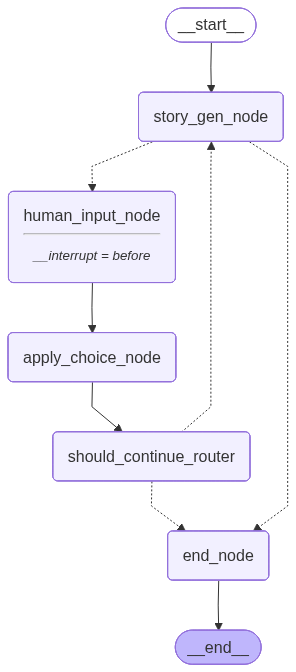

In [ ]:
graph

## Execution

Run the workflow:

In [ ]:
# Simple interactive UI (ipywidgets) for the CYOA graph

import uuid
import ipywidgets as widgets
from IPython.display import display, clear_output

class AdventureUI:
    def __init__(self, graph):
        self.graph = graph

        self.out = widgets.Output(
            layout=widgets.Layout(
                width="100%",
                border="1px solid #ddd",
                padding="12px",
                overflow="auto",
            )
        )

        # Make the box stretch children full-width nicely
        self.choices_box = widgets.VBox(
            layout=widgets.Layout(
                width="100%",
                align_items="stretch",   # important for consistent full-width buttons in flex layouts
            )
        )

        self.restart_btn = widgets.Button(
            description="Restart",
            button_style="warning",
            layout=widgets.Layout(width="160px", margin="10px 0 0 0"),
        )
        self.restart_btn.on_click(self._on_restart)

        self.thread_id = None
        self.config = None
        self.input_data = None  # <-- store it so Restart works

        # Optional: if your button labels are long, this helps them wrap + left-align.
        display(widgets.HTML("""
        <style>
          .widget-button .btn {
            white-space: normal !important;
            text-align: left !important;
          }
        </style>
        """))


    def _new_thread(self):
        self.thread_id = str(uuid.uuid4())
        self.config = {"configurable": {"thread_id": self.thread_id}}

    def _initial_state(self,input_data):
        tone = None
        if input_data:
            tone = {"story_genre": input_data.get("story_genre","fantasy adventure"),
                    "story_theme": input_data.get("story_theme","Epic dungeon exploration"),
                    "story_setting": input_data.get("story_setting", "high fantasy world full of magic, monsters, and maidens"),
                    "profanity_guard": False, "thematic_boundaries": [],
                    "style": input_data.get("story_genre","fantasy adventure") + " " + input_data.get("story_theme","Epic dungeon exploration") + " " + input_data.get("story_setting", "high fantasy world full of magic, monsters, and maidens")
                    }
        user_name = input_data.get("user_name", "Player")
        user_age = input_data.get("user_age", 18)
        user_pronouns = input_data.get("user_pronouns", "they/them")
        return {
            "turn_index": 0,
            "user_pronouns": user_pronouns,
            "user_name": user_name,
            "user_age": user_age,
            "story_so_far": [],
            "messages": [],
            "current_segment": "",
            "choices": [],
            "selected_choice": None,
            "memory_summary": "",
            "facts": {},
            "tone": tone or {"style": "adventure", "profanity_guard": False, "thematic_boundaries": []},
            "telemetry": [],
            "max_turns": 12,
            "run_status": "running",
            "end_reason": None,
        }

    def start(self, input_data):
        self.input_data = input_data  # <-- save for restart
        self._new_thread()
        display(widgets.VBox([self.out, self.choices_box, self.restart_btn],
                             layout=widgets.Layout(width="100%")))
        self.run_loop(initial_state=self._initial_state(input_data))

    def run_loop(self, initial_state=None):
        last_state = None

        # Stream until interrupt or completion
        for event in self.graph.stream(initial_state, config=self.config, stream_mode="values"):
            last_state = event

        if last_state is None:
            try:
                last_state = self.graph.get_state(self.config).values
            except Exception:
                last_state = {}

        self.render(last_state)

    def render(self, state):
        status = state.get("run_status", "unknown")
        turn = state.get("turn_index", 0)
        segment = state.get("current_segment", "")
        epilogue = state.get("epilogue", "")

        with self.out:
            clear_output()
            print(f"Turn: {turn} | Status: {status}")
            if state.get("end_reason"):
                print(f"End reason: {state.get('end_reason')}")
            if segment:
                print("\n" + segment)
            if epilogue:
                print("\n---\n" + epilogue)

        choices = state.get("choices") or []
        if status == "waiting_for_human" and len(choices) >= 1:
            btns = []
            for i, c in enumerate(choices):
                b = widgets.Button(description=f"{i+1}. {c}", layout=widgets.Layout(width="100%"))
                b.on_click(lambda _btn, idx=i: self._on_choice(idx))
                btns.append(b)
            self.choices_box.children = tuple(btns)
        else:
            self.choices_box.children = (widgets.HTML("<i>No choices available.</i>"),)

    def _on_choice(self, idx: int):
        # Update the checkpointed state at the point of interruption, then resume
        self.graph.update_state(self.config, {"selected_choice": idx}, as_node="human_input_node")
        self.run_loop(initial_state=None)

    def _on_restart(self, _btn):
        self._new_thread()
        self.run_loop(initial_state=self._initial_state(self.input_data))

# Run it
try:
  ui = AdventureUI(graph)
  ui.start(input_data)
except Exception as e:
  print(f"Error: {e}. \n Choices: {ui.graph.state.get("choices")}")

HTML(value='\n        <style>\n          .widget-button .btn {\n            white-space: normal !important;\n …

AttributeError: 'list' object has no attribute 'text'